In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, ReLU, Activation
import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline

In [2]:
# Experiment setup
# a = np.random.rand() + 1 # [1,2]
# b = np.random.rand() * 0.5 # [1,5]
# c = np.random.rand() + 

a, b, c = 1, 5, 0
def random_sin(x, noise=False):
    if noise:
        return a * np.sin(b * x + c) + 0.1 * np.random.normal(size=np.shape(x))
    return a * np.sin(b * x + c)
a,b,c

(1, 5, 0)

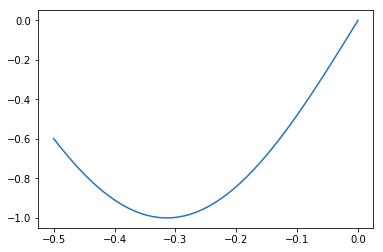

In [3]:
# Plot y = a * sin(bx + c)
X_plot = np.linspace(-0.5, 0, 50).astype(np.float32)
Y_plot = random_sin(X_plot).astype(np.float32)
plt.plot(X_plot, Y_plot)

In [66]:
# Setup model
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
    Dense(64, activation='relu',input_shape=(1,)),
#     Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)
])
init_weight_copy = model.get_weights()

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 33,281
Trainable params: 33,281
Non-trainable params: 0
_________________________________________________________________


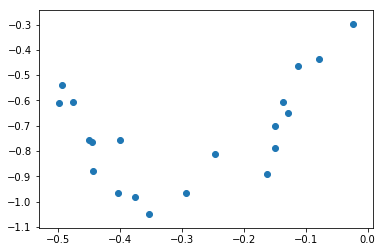

In [67]:
np.random.seed(666)

X_random = np.random.uniform(-.5, 0, 20).astype(np.float32)
Y_random = random_sin(X_random, True).astype(np.float32)
plt.scatter(X_random, Y_random)
# plt.plot(X_plot, Y_plot)

In [6]:
def loss_fn(y_pred, y_target):
    return tf.reduce_mean((y_pred - y_target) ** 2)

In [7]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)

In [9]:
loss_fn(np.array([1,4]), np.array([2,3]))

<tf.Tensor: id=150, shape=(), dtype=int64, numpy=1>

In [86]:
iters = 1000
reg_candidate = [0., 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001, 0.00003, 0.00001]

loss_hist = {
}

for reg in reg_candidate:
    
    loss_hist[reg] = {
        'train':[],
        'val':[],
        
    }
    
    lr = 0.01
    model.set_weights(init_weight_copy)

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    for i in range(1, iters+1):
        input_X = tf.Variable(X_random.reshape([-1,1]))
        with tf.GradientTape() as tape1:
            with tf.GradientTape() as tape2:
                out_y = model(input_X)
            grad_fx = tape2.gradient(out_y, input_X)
            loss = loss_fn(out_y, Y_random.reshape([-1,1])) + reg * tf.reduce_mean(grad_fx ** 2)
        grads = tape1.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        y_pred_all = model(X_plot.reshape([-1,1]))
        eval_loss = loss_fn(y_pred_all, Y_plot.reshape([-1,1]))
        
        loss_hist[reg]['train'].append(loss)
        loss_hist[reg]['val'].append(eval_loss)
        if i % 200 == 0:
            optimizer.lr = optimizer.lr/2
            
        if i % 200 == 0:

            print(f'training loss: epoch {i} = {loss}')
            print(f'evaluation loss: epoch {i} = {eval_loss}')
        
    loss_hist[reg]['pred'] = y_pred_all
    
            
#     if i % 10:
#         optimizer.lr = optimizer.lr/2
        


training loss: epoch 200 = 0.003393554361537099
evaluation loss: epoch 200 = 0.006272875238209963
training loss: epoch 400 = 0.0026644242461770773
evaluation loss: epoch 400 = 0.006738810334354639
training loss: epoch 600 = 0.0025269784964621067
evaluation loss: epoch 600 = 0.006996102165430784
training loss: epoch 800 = 0.0024792617186903954
evaluation loss: epoch 800 = 0.007100616581737995
training loss: epoch 1000 = 0.0024443583097308874
evaluation loss: epoch 1000 = 0.0072001195512712
training loss: epoch 200 = 0.03218235448002815
evaluation loss: epoch 200 = 0.057076193392276764
training loss: epoch 400 = 0.03203270956873894
evaluation loss: epoch 400 = 0.057299479842185974
training loss: epoch 600 = 0.03226401284337044
evaluation loss: epoch 600 = 0.05716022476553917
training loss: epoch 800 = 0.032163914293050766
evaluation loss: epoch 800 = 0.05721563473343849
training loss: epoch 1000 = 0.032195013016462326
evaluation loss: epoch 1000 = 0.057225074619054794
training loss: epoc

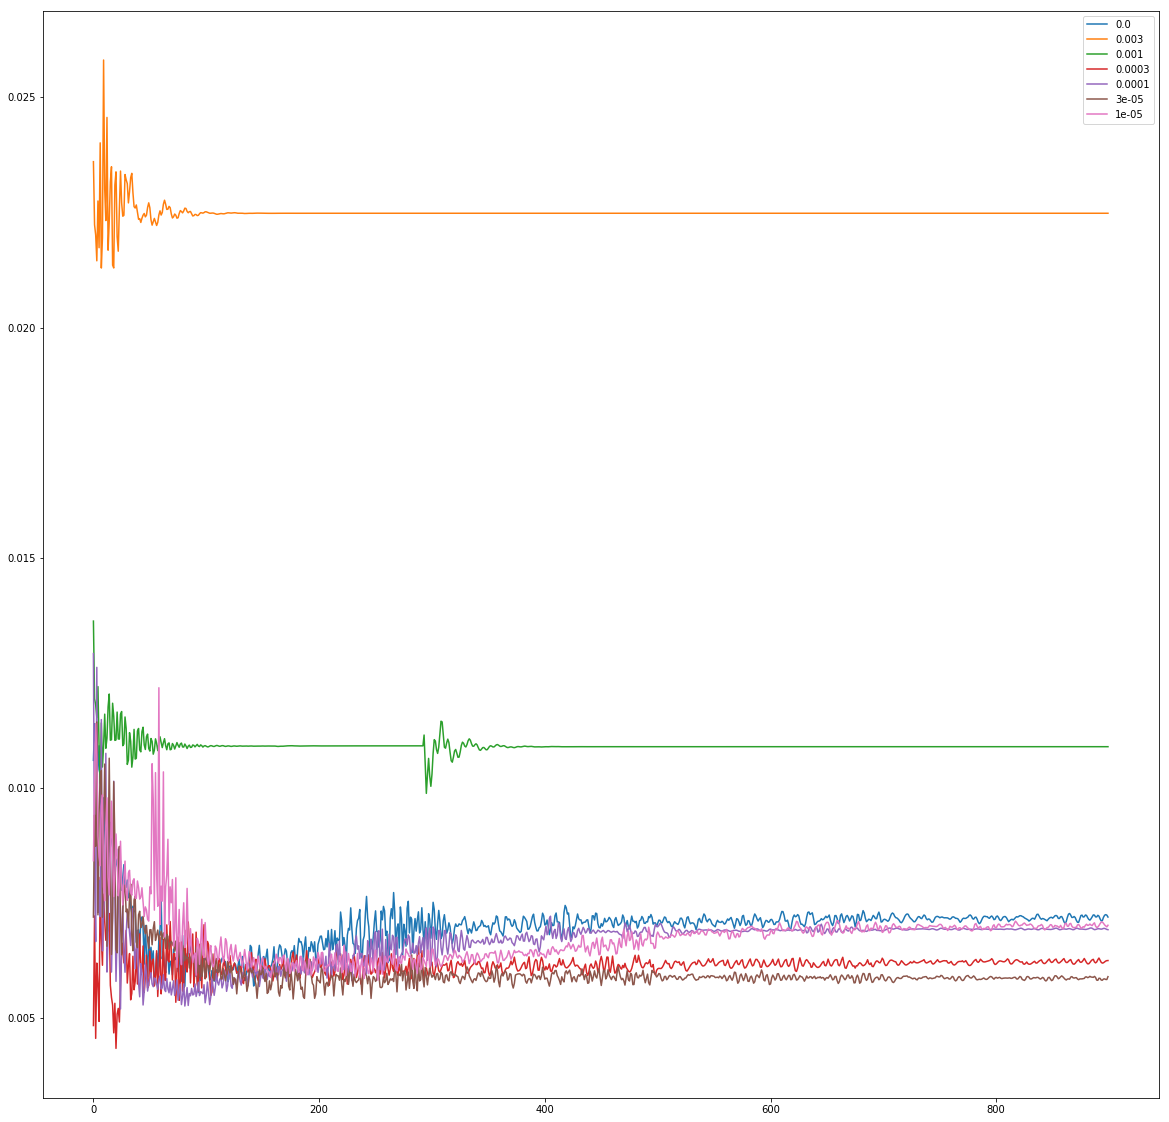

In [87]:
plt.figure(figsize=(20,20))
reg_show = [0., 0.003, 0.001, 0.0003, 0.0001,0.00003,0.00001]
for key in reg_show:
    plt.plot(loss_hist[key]['val'][100:], label=str(key))

plt.legend()

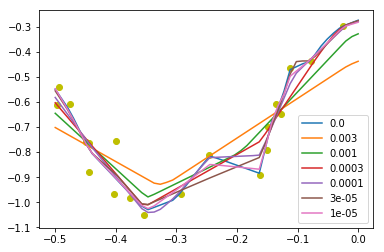

In [88]:
# y_pred_all = model(X_plot.reshape([-1,1]))
plot_idxs = [0., 0.003, 0.001, 0.0003, 0.0001,0.00003,0.00001]
for idx in plot_idxs:
    plt.plot(X_plot,loss_hist[idx]['pred'][:,0], label=str(idx))
# plt.plot(X_plot,Y_plot)
plt.scatter(X_random, Y_random, color='y')
plt.legend()

In [13]:
X_random.shape

(20,)

In [91]:
# Noise injection with auto adjust

iters = 1000
noise_candidate = [0., 1., 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001]
momentum = 1.
update_noise_iter = 100
start_attack = 0
eps = 1e-4

loss_hist = {
}

for noise in noise_candidate:
    init_noise = noise
    loss_hist[init_noise] = {
        'train':[],
        'val':[],
        'grad':[],
        'alpha':[]
    }
    
    lr = 0.01
    model.set_weights(init_weight_copy)

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    prev_grad = None
    cur_grad = 0

    for i in range(1, iters+1):
        
        if i > start_attack:
            input_X = tf.Variable(X_random.reshape([-1,1]) + np.random.normal(size=(X_random.shape[0],1)) * noise, 
                                  dtype=tf.float32)
        else:    
            input_X = tf.Variable(X_random.reshape([-1,1]))
#             print(type(input_X))
            
        with tf.GradientTape() as tape1:
            with tf.GradientTape() as tape2:
                out_y = model(input_X)
                
            grad_fx = tape2.gradient(out_y, input_X)
            grad_l2 = tf.reduce_mean(grad_fx ** 2)
            
            loss = loss_fn(out_y, Y_random.reshape([-1,1]))
            
        
        
        grads = tape1.gradient(loss, model.trainable_variables)
        cur_grad += grad_l2
        # Noise weight  adjustment
        if i % update_noise_iter == 0:
            if prev_grad is None:
                prev_grad = 0
            else:
                noise = (momentum + (1 - momentum) * (cur_grad / (prev_grad + eps))) * noise
                noise = noise.numpy()
                
            prev_grad = cur_grad
            cur_grad = 0
            
        
        
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        y_pred_all = model(X_plot.reshape([-1,1]))
        eval_loss = loss_fn(y_pred_all, Y_plot.reshape([-1,1]))
        
        loss_hist[init_noise]['train'].append(loss)
        loss_hist[init_noise]['val'].append(eval_loss)
        loss_hist[init_noise]['grad'].append(grad_l2)
        loss_hist[init_noise]['alpha'].append(noise)
        if i % 200 == 0:
            optimizer.lr = optimizer.lr/2
            
        if i % 200 == 0:

            print(f'training loss: epoch {i} = {loss}')
            print(f'evaluation loss: epoch {i} = {eval_loss}')
        
    loss_hist[init_noise]['pred'] = y_pred_all
    
            
#     if i % 10:
#         optimizer.lr = optimizer.lr/2
        


training loss: epoch 200 = 0.003393554361537099
evaluation loss: epoch 200 = 0.006272875238209963
training loss: epoch 400 = 0.0026644242461770773
evaluation loss: epoch 400 = 0.006738810334354639
training loss: epoch 600 = 0.0025269784964621067
evaluation loss: epoch 600 = 0.006996102165430784
training loss: epoch 800 = 0.0024792617186903954
evaluation loss: epoch 800 = 0.007100616581737995
training loss: epoch 1000 = 0.0024443583097308874
evaluation loss: epoch 1000 = 0.0072001195512712
training loss: epoch 200 = 0.038730017840862274
evaluation loss: epoch 200 = 0.08149337023496628
training loss: epoch 400 = 0.03909296542406082
evaluation loss: epoch 400 = 0.08126214891672134
training loss: epoch 600 = 0.03897782415151596
evaluation loss: epoch 600 = 0.07995644211769104
training loss: epoch 800 = 0.03776481747627258
evaluation loss: epoch 800 = 0.08058126270771027
training loss: epoch 1000 = 0.038119688630104065
evaluation loss: epoch 1000 = 0.07999077439308167
training loss: epoch 2

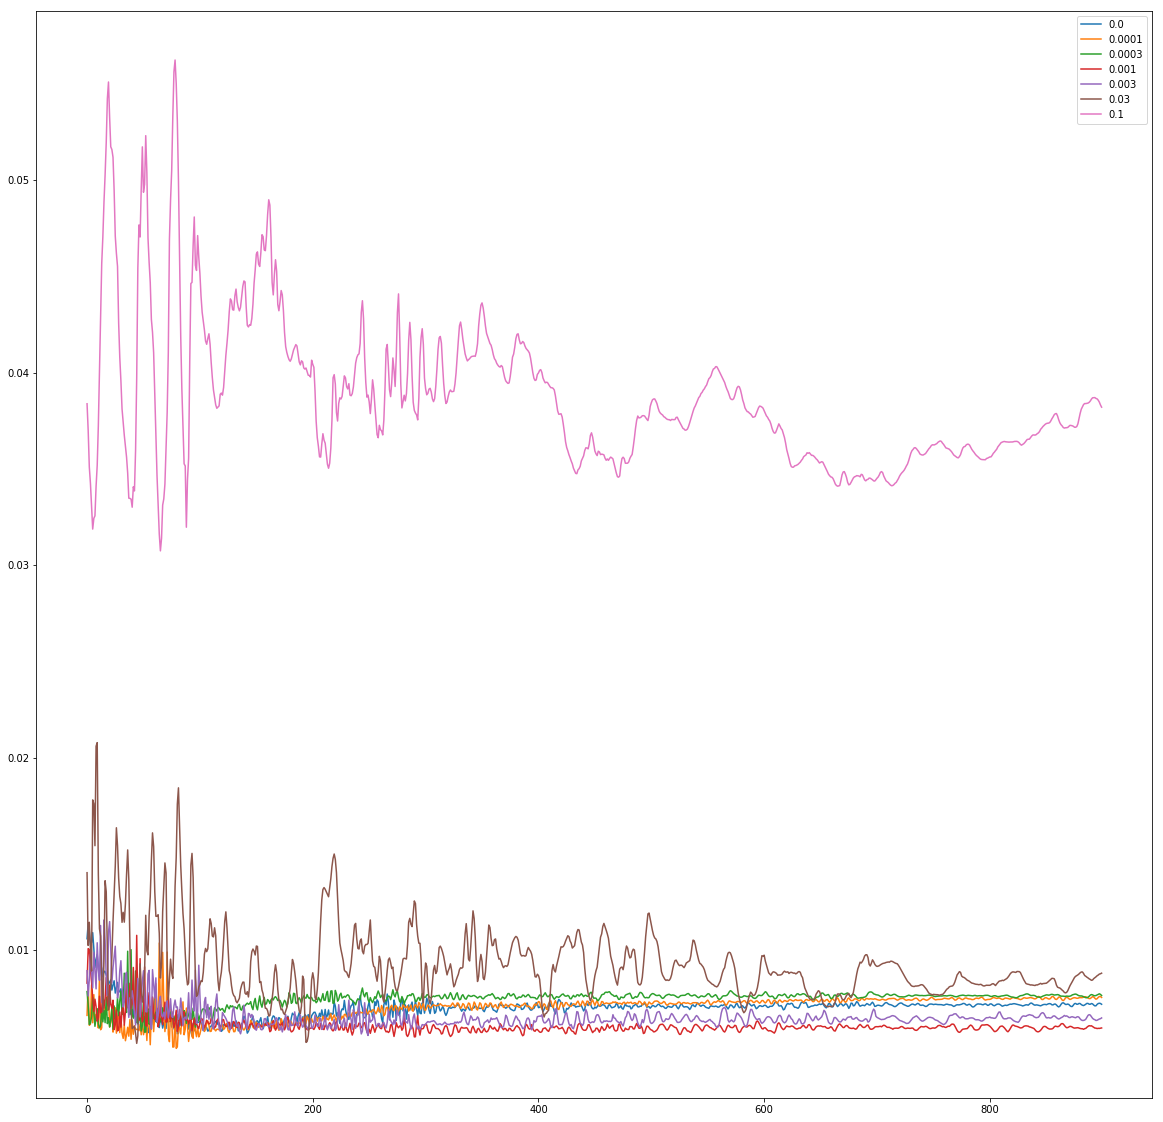

In [107]:
plt.figure(figsize=(20,20))
noise_show = [0.,0.03,0.1,0.003,0.001,0.0003,0.0001 ]
noise_show.sort()
for key in noise_show:
    
    plt.plot(loss_hist[key]['val'][100:], label=str(key))

plt.legend()

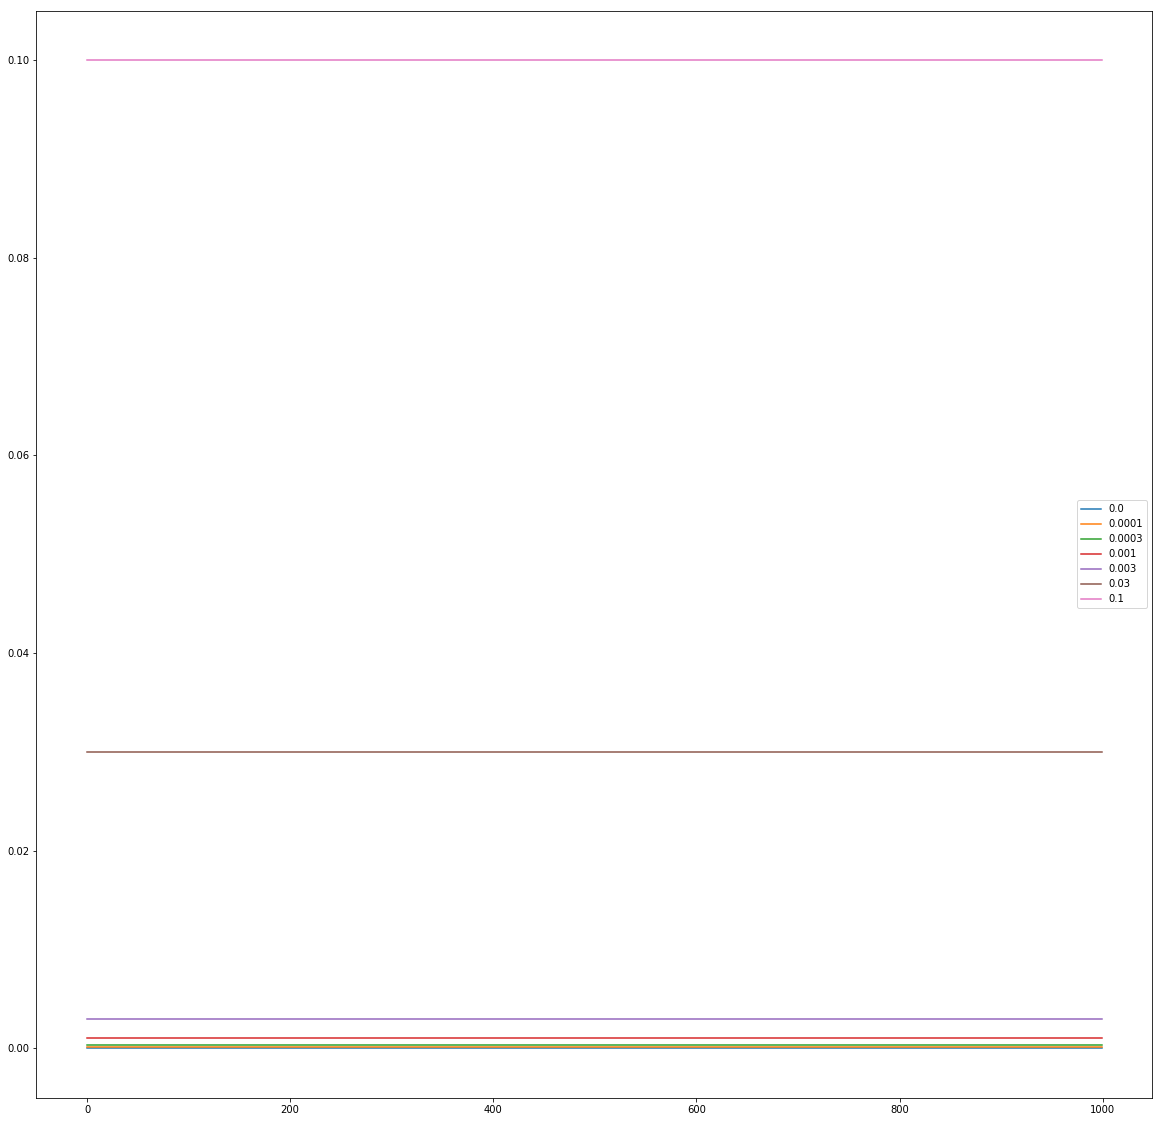

In [93]:
plt.figure(figsize=(20,20))
noise_show = [0.,0.03,0.1, 0.003, 0.001, 0.0003, 0.0001]
noise_show.sort()
for key in noise_show:
    plt.plot(loss_hist[key]['alpha'], label=str(key))

plt.legend()

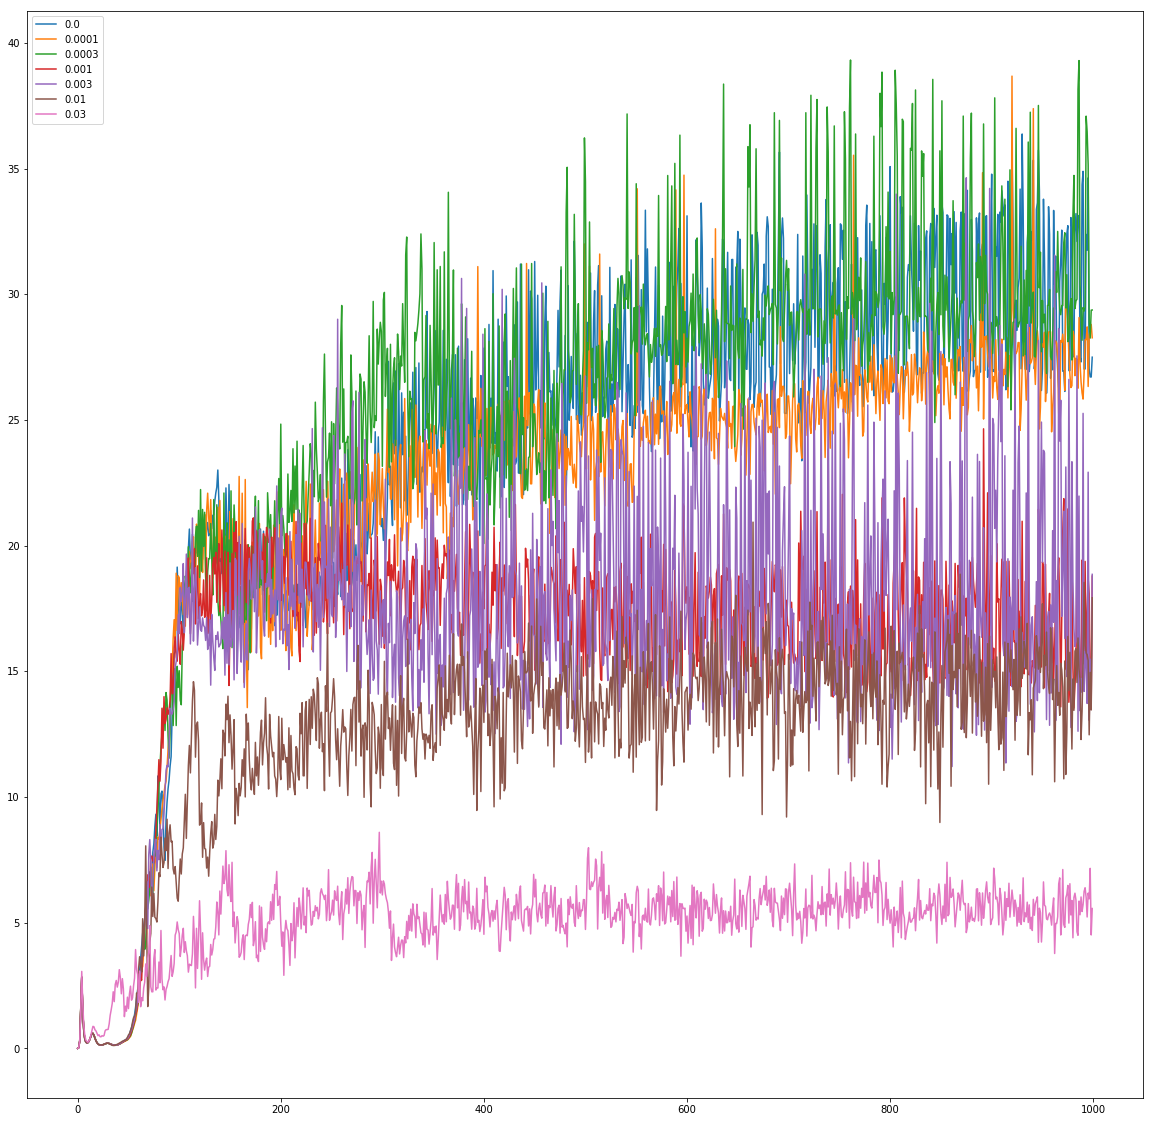

In [94]:
plt.figure(figsize=(20,20))
noise_show = [0.,0.03,0.01, 0.003, 0.001, 0.0003, 0.0001]
# noise_show = [0.1]
noise_show.sort()
for key in noise_show:
    plt.plot(loss_hist[key]['grad'], label=str(key))

plt.legend()

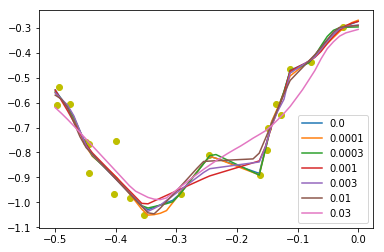

In [95]:
# y_pred_all = model(X_plot.reshape([-1,1]))
# plot_idxs = [0.003,0.,0.001, 0.1,0.03]
plot_idxs = noise_show
for idx in plot_idxs:
    plt.plot(X_plot,loss_hist[idx]['pred'][:,0], label=str(idx))
# plt.plot(X_plot,Y_plot)
plt.scatter(X_random, Y_random, color='y')
plt.legend()

In [162]:
# Noise injection with auto adjust / accumulate gradient norm


iters = 2000
# noise_candidate = [0., 1., 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001]
noise_candidate = [0., 0.1, 0.03, 0.01]
momentum = 0.9
update_noise_iter = 100
start_attack = 100
eps = 1e-4

loss_hist = {
}

for noise in noise_candidate:
    init_noise = noise
    loss_hist[init_noise] = {
        'train':[],
        'val':[],
        'grad':[],
        'alpha':[],
        'grad_r':[]
    }
    
    lr = 0.01
    model.set_weights(init_weight_copy)

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    prev_grad = 0.
    cur_grad = 0.

    for i in range(1, iters+1):
        
        if i > start_attack:
            input_X = tf.Variable(X_random.reshape([-1,1]) + np.random.normal(size=(X_random.shape[0],1)) * noise, 
                                  dtype=tf.float32)
        else:    
            input_X = tf.Variable(X_random.reshape([-1,1]))
#             print(type(input_X))
            
        with tf.GradientTape() as tape1:
            with tf.GradientTape() as tape2:
                out_y = model(input_X)
                
            grad_fx = tape2.gradient(out_y, input_X)
            grad_l2 = tf.reduce_mean(grad_fx ** 2)
            
            loss = loss_fn(out_y, Y_random.reshape([-1,1]))
            
        
#         print(grad_l2)
        grads = tape1.gradient(loss, model.trainable_variables)
        cur_grad += grad_l2 / update_noise_iter
        
        # Average whole gradient
#         prev_grad = prev_grad * ((i-1) / i) + (grad_l2 / i)
        prev_grad = prev_grad * momentum + grad_l2 * (1 - momentum)
#         print(grad_l2,prev_grad)
        # Noise weight  adjustment
        if i % update_noise_iter == 0:
#             print(cur_grad,prev_grad)
            noise = (momentum + (1 - momentum) * (cur_grad / (prev_grad + eps))) * noise
            noise = noise.numpy()
            loss_hist[init_noise]['grad_r'].append(cur_grad / (prev_grad + eps))

            cur_grad = 0.
            
        
        
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        y_pred_all = model(X_plot.reshape([-1,1]))
        eval_loss = loss_fn(y_pred_all, Y_plot.reshape([-1,1]))
        
        loss_hist[init_noise]['train'].append(loss)
        loss_hist[init_noise]['val'].append(eval_loss)
        loss_hist[init_noise]['grad'].append(grad_l2)
        loss_hist[init_noise]['alpha'].append(noise)
        if i % 400 == 0:
            optimizer.lr = optimizer.lr/2
            
#         if i % 200 == 0:

#             print(f'training loss: epoch {i} = {loss}')
#             print(f'evaluation loss: epoch {i} = {eval_loss}')
        
    loss_hist[init_noise]['pred'] = y_pred_all
    
            
#     if i % 10:
#         optimizer.lr = optimizer.lr/2
        


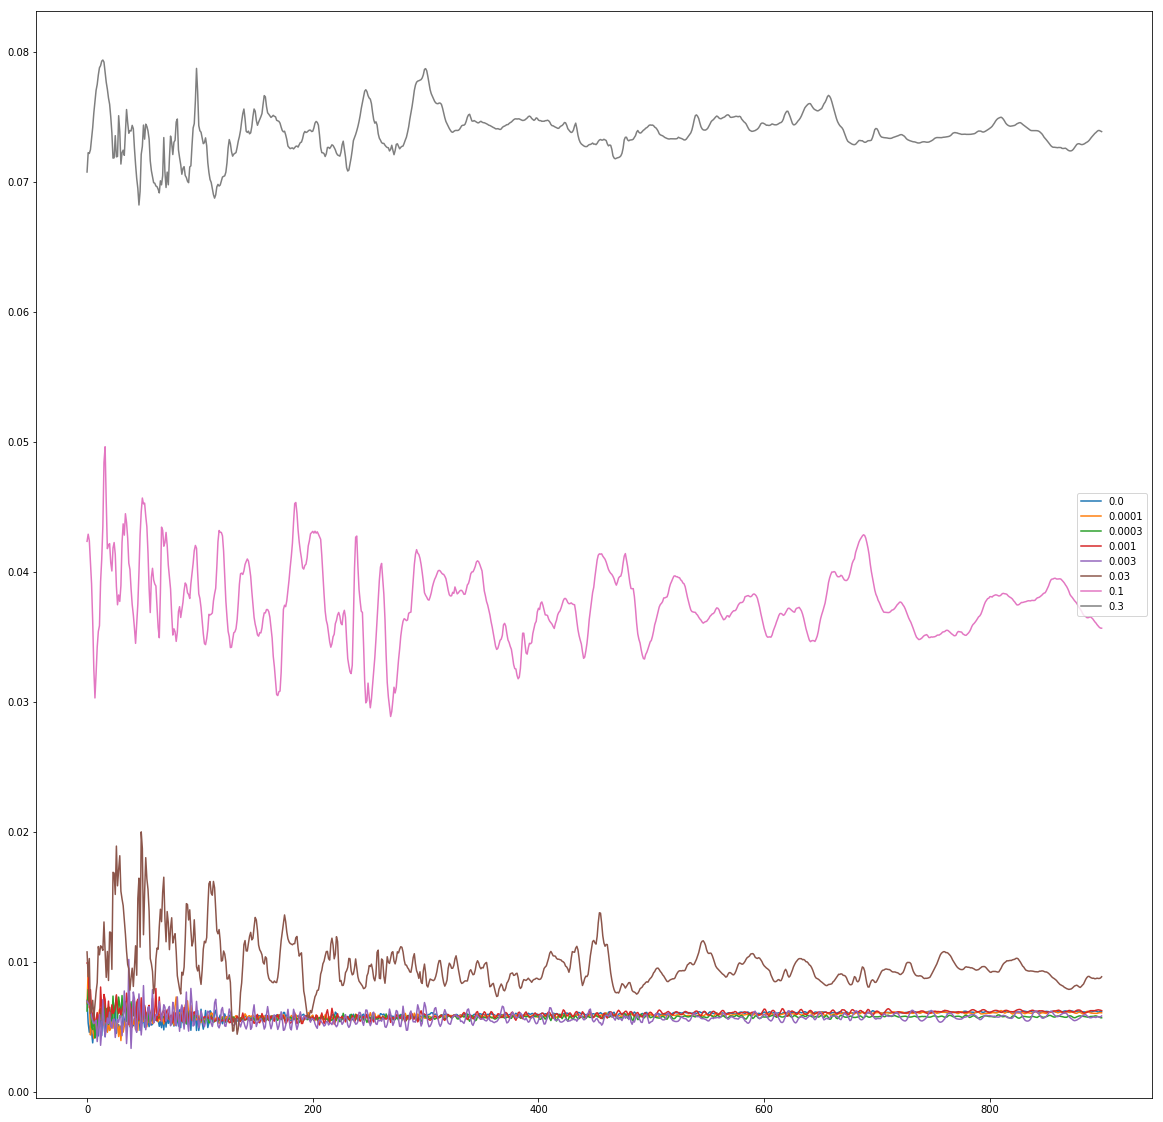

In [16]:
plt.figure(figsize=(20,20))
noise_show = [0.,0.03,0.1,0.3, 0.003, 0.001, 0.0003, 0.0001]
# noise_show = [0., 0.1, 0.03, 0.01]
noise_show.sort()
for key in noise_show:
    plt.plot(loss_hist[key]['val'][100:], label=str(key))

plt.legend()

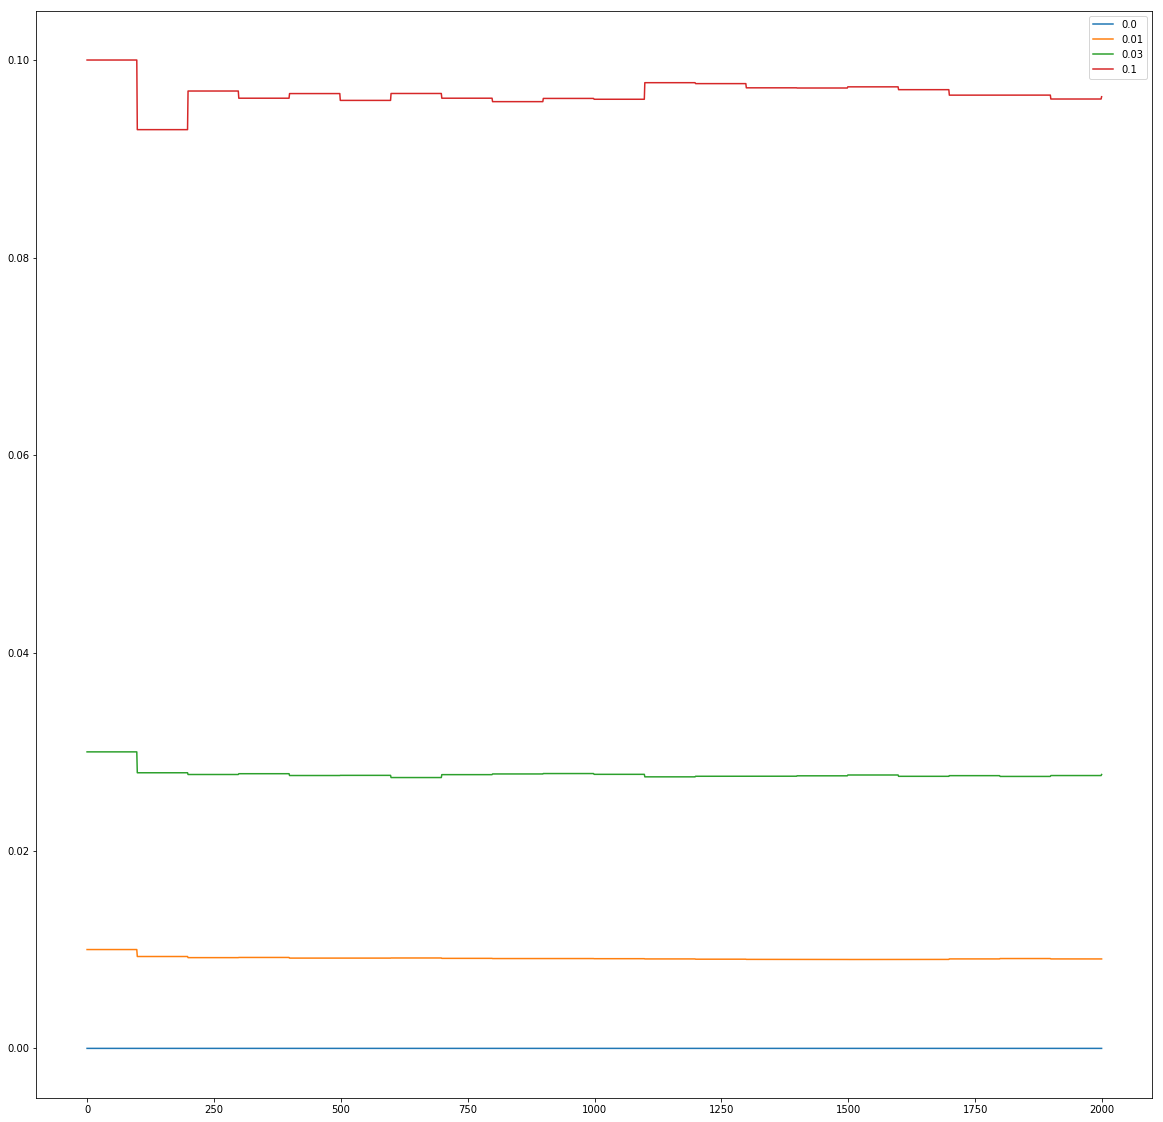

In [171]:
plt.figure(figsize=(20,20))
# noise_show = [0.,0.03,0.1, 0.003, 0.001, 0.0003, 0.0001]
noise_show.sort()
for key in noise_show:
    plt.plot(loss_hist[key]['alpha'], label=str(key))

plt.legend()

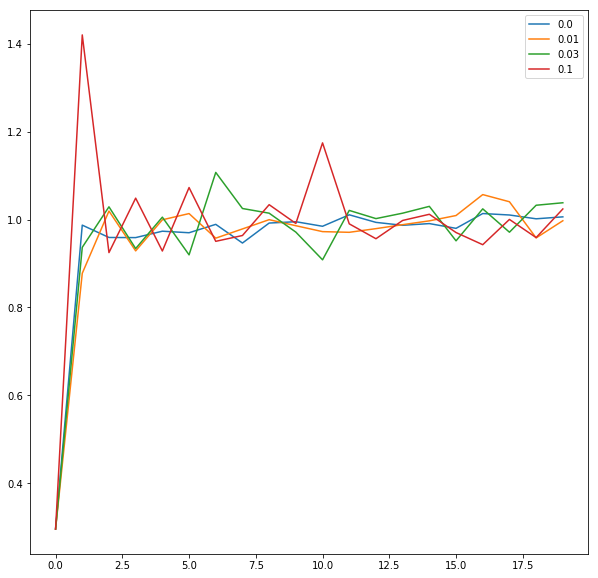

In [172]:
plt.figure(figsize=(10,10))
# noise_show = [0.,0.03,0.1, 0.003, 0.001, 0.0003, 0.0001]
# noise_show = [0.1]
noise_show.sort()
for key in noise_show:
    plt.plot(loss_hist[key]['grad_r'], label=str(key))

plt.legend()

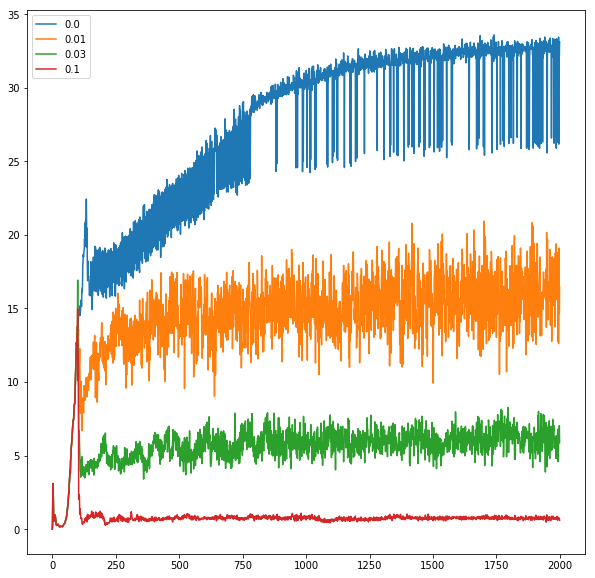

In [173]:
plt.figure(figsize=(10,10))
# noise_show = [0.,0.03,0.1, 0.003, 0.001, 0.0003, 0.0001]
# noise_show = [0.1]
noise_show.sort()
for key in noise_show:
    plt.plot(loss_hist[key]['grad'], label=str(key))

plt.legend()

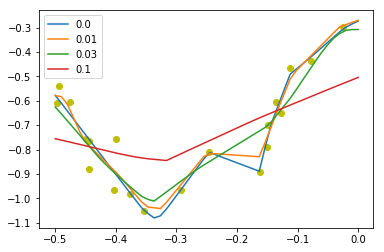

In [174]:
# y_pred_all = model(X_plot.reshape([-1,1]))
# plot_idxs = [0.003,0.,0.001, 0.1,0.03]
plot_idxs = noise_show
for idx in plot_idxs:
    plt.plot(X_plot,loss_hist[idx]['pred'][:,0], label=str(idx))
# plt.plot(X_plot,Y_plot)
plt.scatter(X_random, Y_random, color='y')
plt.legend()

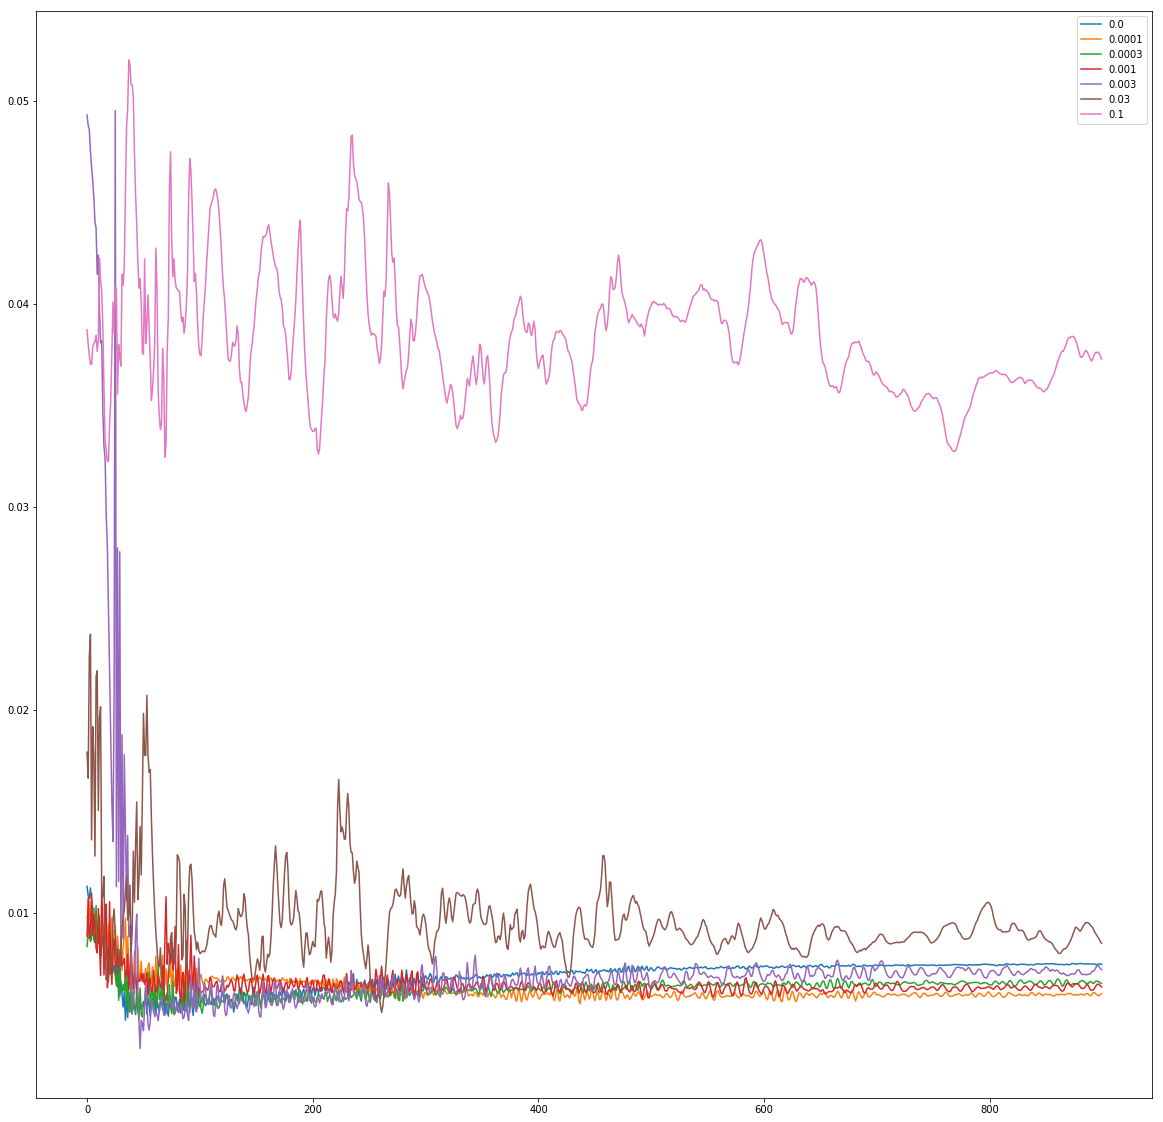

In [39]:
plt.figure(figsize=(20,20))
noise_show = [0.,0.03,0.1, 0.003, 0.001, 0.0003, 0.0001]
noise_show.sort()
for key in noise_show:
    plt.plot(loss_hist[key]['val'][100:], label=str(key))

plt.legend()

In [ ]:
# Noise injection

iters = 1000
noise_candidate = [0., 1., 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001]

loss_hist = {
}

for noise in noise_candidate:
    
    loss_hist[noise] = {
        'train':[],
        'val':[],
        
    }
    
    lr = 0.01
    model.set_weights(init_weight_copy)

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    for i in range(1, iters+1):
        input_X = tf.Variable(X_random.reshape([-1,1])) + np.random.normal(size=(X_random.shape[0],1)) * noise
        with tf.GradientTape() as tape1:
            out_y = model(input_X)
            loss = loss_fn(out_y, Y_random.reshape([-1,1])) + reg * tf.reduce_mean(grad_fx ** 2)
        grads = tape1.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        y_pred_all = model(X_plot.reshape([-1,1]))
        eval_loss = loss_fn(y_pred_all, Y_plot.reshape([-1,1]))
        
        loss_hist[noise]['train'].append(loss)
        loss_hist[noise]['val'].append(eval_loss)
        if i % 200 == 0:
            optimizer.lr = optimizer.lr/2
            
        if i % 200 == 0:

            print(f'training loss: epoch {i} = {loss}')
            print(f'evaluation loss: epoch {i} = {eval_loss}')
        
    loss_hist[noise]['pred'] = y_pred_all
    
            
#     if i % 10:
#         optimizer.lr = optimizer.lr/2
        


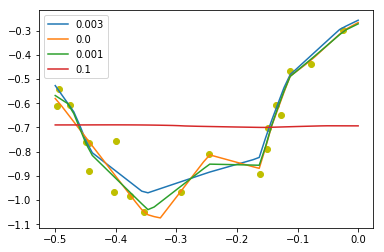

In [49]:
# y_pred_all = model(X_plot.reshape([-1,1]))
plot_idxs = [0.003,0.,0.001, 0.1]
for idx in plot_idxs:
    plt.plot(X_plot,loss_hist[idx]['pred'][:,0], label=str(idx))
# plt.plot(X_plot,Y_plot)
plt.scatter(X_random, Y_random, color='y')
plt.legend()

training loss: epoch 50 = 0.019933635368943214
evaluation loss: epoch 50 = 0.029703013598918915
training loss: epoch 100 = 0.006568977143615484
evaluation loss: epoch 100 = 0.008116676472127438
training loss: epoch 150 = 0.005619261879473925
evaluation loss: epoch 150 = 0.007733286824077368
training loss: epoch 200 = 0.009268280118703842
evaluation loss: epoch 200 = 0.011170858517289162
training loss: epoch 250 = 0.0019142180681228638
evaluation loss: epoch 250 = 0.011881261132657528
training loss: epoch 300 = 0.0018151088152080774
evaluation loss: epoch 300 = 0.012683611363172531
training loss: epoch 350 = 0.0017784502124413848
evaluation loss: epoch 350 = 0.013334228657186031
training loss: epoch 400 = 0.0017906107241287827
evaluation loss: epoch 400 = 0.012024977244436741
training loss: epoch 450 = 0.0018121935427188873
evaluation loss: epoch 450 = 0.010897698812186718
training loss: epoch 500 = 0.0018728472059592605
evaluation loss: epoch 500 = 0.011697692796587944


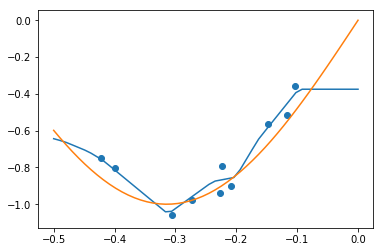

In [187]:
iters = 500
reg_candidate = [0., 1., 0.3, 0.1, 0.03, 0.01, 0.003, 0.001]

loss_hist = {
}


lr = 0.1
model.set_weights(init_weight_copy)
reg = 0.
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

for i in range(1, iters+1):
    input_X = tf.Variable(X_random.reshape([-1,1]))
    with tf.GradientTape() as tape1:
#         with tf.GradientTape() as tape2:
        out_y = model(input_X)
#         grad_fx = tape2.gradient(out_y, input_X)
#         print((out_y, Y_random.reshape([-1,1])))
        loss = loss_fn(out_y, Y_random.reshape([-1,1])) #+ reg * tf.reduce_mean(grad_fx ** 2)
    grads = tape1.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    y_pred_all = model(X_plot.reshape([-1,1]))
    eval_loss = loss_fn(y_pred_all, Y_plot.reshape([-1,1]))

#     if i % 100:
#         optimizer.lr = optimizer.lr/2

    if i % 50 == 0:

        print(f'training loss: epoch {i} = {loss}')
        print(f'evaluation loss: epoch {i} = {eval_loss}')

# y_pred_all = model(X_plot.reshape([-1,1]))
plt.plot(X_plot,y_pred_all.numpy()[:,0])
plt.plot(X_plot,Y_plot)
plt.scatter(X_random, Y_random)     

In [ ]:
model.compile()

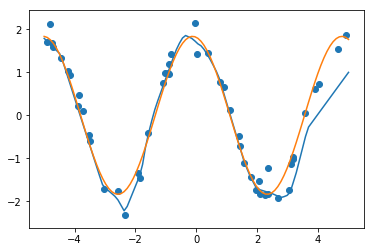

In [92]:
# y_pred_all = model(X_plot.reshape([-1,1]))
plt.plot(X_plot,y_pred_all.numpy()[:,0])
plt.plot(X_plot,Y_plot)
plt.scatter(X_random, Y_random)

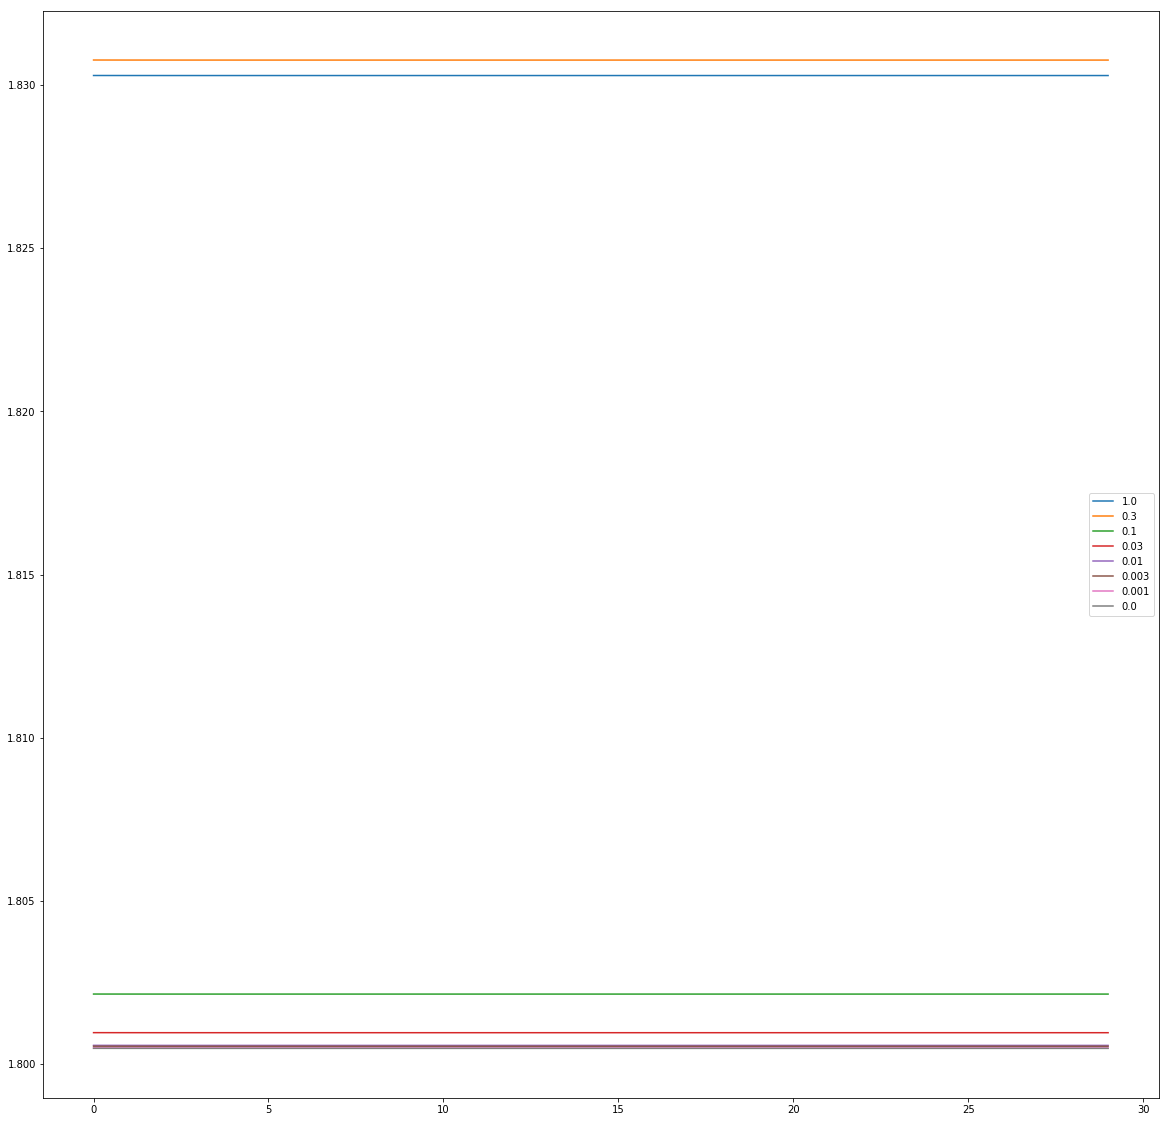

In [118]:
plt.figure(figsize=(20,20))
for key in loss_hist:
    plt.plot(loss_hist[key]['val'][20:50], label=str(key))

plt.legend()

# Classification

In [272]:
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

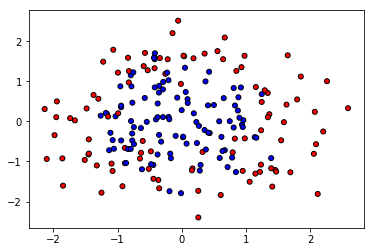

In [387]:
# X, y = make_moons(noise=0.5, random_state=100)
X, y = make_circles(200, noise=0.3, factor=0.5, random_state=1)
# X, y = make_classification(100, n_features=2, n_redundant=0, n_informative=2,
#                            random_state=0, n_clusters_per_class=1)
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.6)

from matplotlib.colors import ListedColormap

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright,
                   edgecolors='black', s=25)

In [384]:
# Setup model
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
    Dense(100, activation='relu',input_shape=(2,)),
#     Dense(64, activation='relu'),
    Dense(200, activation='relu'),
    Dense(100, activation='relu'),
    Dense(1, activation='sigmoid')
])
init_weight_copy = model.get_weights()

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               300       
_________________________________________________________________
dense_1 (Dense)              (None, 200)               20200     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 40,701
Trainable params: 40,701
Non-trainable params: 0
_________________________________________________________________


In [244]:
y

array([0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0])

In [252]:
h=0.02
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))


In [405]:
def bin_loss(y_pred, y_target):
    return tf.reduce_mean(-tf.math.log(tf.where(y_target==1, x=y_pred, y=1-y_pred) + 1e-5))

training loss: epoch 50 = 0.575379490852356
evaluation loss: epoch 50 = 0.21206358075141907
evaluation acc: epoch 50 = 0.65
training loss: epoch 100 = 0.43180257081985474
evaluation loss: epoch 100 = 0.17136475443840027
evaluation acc: epoch 100 = 0.7333333333333333
training loss: epoch 150 = 0.34016770124435425
evaluation loss: epoch 150 = 0.15304026007652283
evaluation acc: epoch 150 = 0.7916666666666666
training loss: epoch 200 = 0.299682080745697
evaluation loss: epoch 200 = 0.15055878460407257
evaluation acc: epoch 200 = 0.8
training loss: epoch 250 = 0.28100061416625977
evaluation loss: epoch 250 = 0.15208688378334045
evaluation acc: epoch 250 = 0.8
training loss: epoch 300 = 0.2701142132282257
evaluation loss: epoch 300 = 0.1542789489030838
evaluation acc: epoch 300 = 0.8
training loss: epoch 350 = 0.26287445425987244
evaluation loss: epoch 350 = 0.1562793105840683
evaluation acc: epoch 350 = 0.8
training loss: epoch 400 = 0.2572445869445801
evaluation loss: epoch 400 = 0.157712

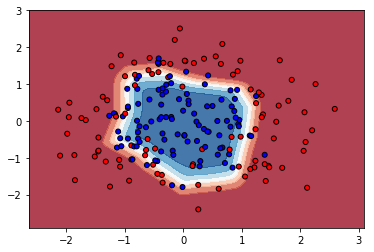

In [391]:
def bin_loss(y_pred, y_target):
    return tf.reduce_mean(-tf.math.log(tf.where(y_target==1, x=y_pred, y=1-y_pred) + 1e-5))

iters = 500

lr = 0.1
model.set_weights(init_weight_copy)
reg = 0.0
optimizer = tf.keras.optimizers.SGD(learning_rate=lr)

for i in range(1, iters+1):
    input_X = tf.Variable(X_train)
    with tf.GradientTape() as tape1:
        with tf.GradientTape() as tape2:
            out_y = model(input_X)
        grad_fx = tape2.gradient(out_y, input_X)
#         print(grad_fx)
#         print((out_y, Y_random.reshape([-1,1])))
        loss = bin_loss(out_y, y_train.reshape([-1,1])) + reg * tf.reduce_mean(tf.cast(tf.reduce_sum(grad_fx ** 2, axis=1), tf.float32) / (1. - y_train.reshape([-1,1]) - out_y) ** 2)
    grads = tape1.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    y_pred_all = model(X_test)
    eval_loss = loss_fn(y_pred_all, y_test.reshape([-1,1]))
    
    eval_acc = np.mean(1 - np.abs(np.rint(y_pred_all) - y_test.reshape([-1,1])))
    

#     if i % 500 == 0:
#         optimizer.lr = optimizer.lr/2

    if i % 50 == 0:

        print(f'training loss: epoch {i} = {loss}')
        print(f'evaluation loss: epoch {i} = {eval_loss}')
        print(f'evaluation acc: epoch {i} = {eval_acc}')
#         print(1 - np.abs(np.rint(y_pred_all) - y_test))


x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.contourf(xx, yy, Z, cmap=cm, alpha=.8)


plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright,
                   edgecolors='black', s=25)

# # y_pred_all = model(X_plot.reshape([-1,1]))
# plt.plot(X_plot,y_pred_all.numpy()[:,0])
# plt.plot(X_plot,Y_plot)
# plt.scatter(X_random, Y_random)     

In [418]:
iters = 1000
reg_candidate = [0., 1., 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001]

loss_hist = {
}

for reg in reg_candidate:
    
    loss_hist[reg] = {
        'train':[],
        'val':[],
        'acc':[]
        
    }
    
    lr = 0.03
    model.set_weights(init_weight_copy)

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    for i in range(1, iters+1):
        input_X = tf.Variable(X_train)
        with tf.GradientTape() as tape1:
            with tf.GradientTape() as tape2:
                out_y = model(input_X)
            grad_fx = tape2.gradient(out_y, input_X)
    #         print(grad_fx)
    #         print((out_y, Y_random.reshape([-1,1])))
            multiplier = tf.stop_gradient((1. - y_train.reshape([-1,1]) - out_y) ** 2 + 0.1)
#             multiplier = (1. - y_train.reshape([-1,1]) - out_y) ** 2
#             multiplier = 1
            loss = bin_loss(out_y, y_train.reshape([-1,1])) + reg * tf.reduce_mean(tf.cast(tf.reduce_sum(grad_fx ** 2, axis=1), tf.float32) / multiplier)
        grads = tape1.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        y_pred_all = model(X_test)
        eval_loss = loss_fn(y_pred_all, y_test.reshape([-1,1]))

        eval_acc = np.mean(1 - np.abs(np.rint(y_pred_all) - y_test.reshape([-1,1])))
        loss_hist[reg]['train'].append(loss)
        loss_hist[reg]['val'].append(eval_loss)
        loss_hist[reg]['acc'].append(eval_acc)


        if i % 200 == 0:
            optimizer.lr = optimizer.lr/2

        if i % 200 == 0:

            print(f'training loss: epoch {i} = {loss}')
            print(f'evaluation loss: epoch {i} = {eval_loss}')
            print(f'evaluation acc: epoch {i} = {eval_acc}')

# for reg in reg_candidate:
    
#     loss_hist[reg] = {
#         'train':[],
#         'val':[],
        
#     }
    
#     lr = 0.01
#     model.set_weights(init_weight_copy)

#     optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

#     for i in range(1, iters+1):
#         input_X = tf.Variable(X_random.reshape([-1,1]))
#         with tf.GradientTape() as tape1:
#             with tf.GradientTape() as tape2:
#                 out_y = model(input_X)
#             grad_fx = tape2.gradient(out_y, input_X)
#             loss = loss_fn(out_y, Y_random.reshape([-1,1])) + reg * tf.reduce_mean(grad_fx ** 2)
#         grads = tape1.gradient(loss, model.trainable_variables)
#         optimizer.apply_gradients(zip(grads, model.trainable_variables))
#         y_pred_all = model(X_plot.reshape([-1,1]))
#         eval_loss = loss_fn(y_pred_all, Y_plot.reshape([-1,1]))
        
#         loss_hist[reg]['train'].append(loss)
#         loss_hist[reg]['val'].append(eval_loss)
#         if i % 200 == 0:
#             optimizer.lr = optimizer.lr/2
            
#         if i % 200 == 0:

#             print(f'training loss: epoch {i} = {loss}')
#             print(f'evaluation loss: epoch {i} = {eval_loss}')
        
#     loss_hist[reg]['pred'] = y_pred_all
    
            
#     if i % 10:
#         optimizer.lr = optimizer.lr/2
        


training loss: epoch 200 = 0.02555271051824093
evaluation loss: epoch 200 = 0.24156919121742249
evaluation acc: epoch 200 = 0.7333333333333333
training loss: epoch 400 = 0.003562684403732419
evaluation loss: epoch 400 = 0.24098920822143555
evaluation acc: epoch 400 = 0.7416666666666667
training loss: epoch 600 = 0.0011732520069926977
evaluation loss: epoch 600 = 0.24756498634815216
evaluation acc: epoch 600 = 0.7333333333333333
training loss: epoch 800 = 0.000770163256675005
evaluation loss: epoch 800 = 0.247576504945755
evaluation acc: epoch 800 = 0.7416666666666667
training loss: epoch 1000 = 0.0006252763560041785
evaluation loss: epoch 1000 = 0.24801760911941528
evaluation acc: epoch 1000 = 0.7416666666666667
training loss: epoch 200 = 0.6261737942695618
evaluation loss: epoch 200 = 0.2070082128047943
evaluation acc: epoch 200 = 0.7833333333333333
training loss: epoch 400 = 0.6262856721878052
evaluation loss: epoch 400 = 0.20703701674938202
evaluation acc: epoch 400 = 0.775
training

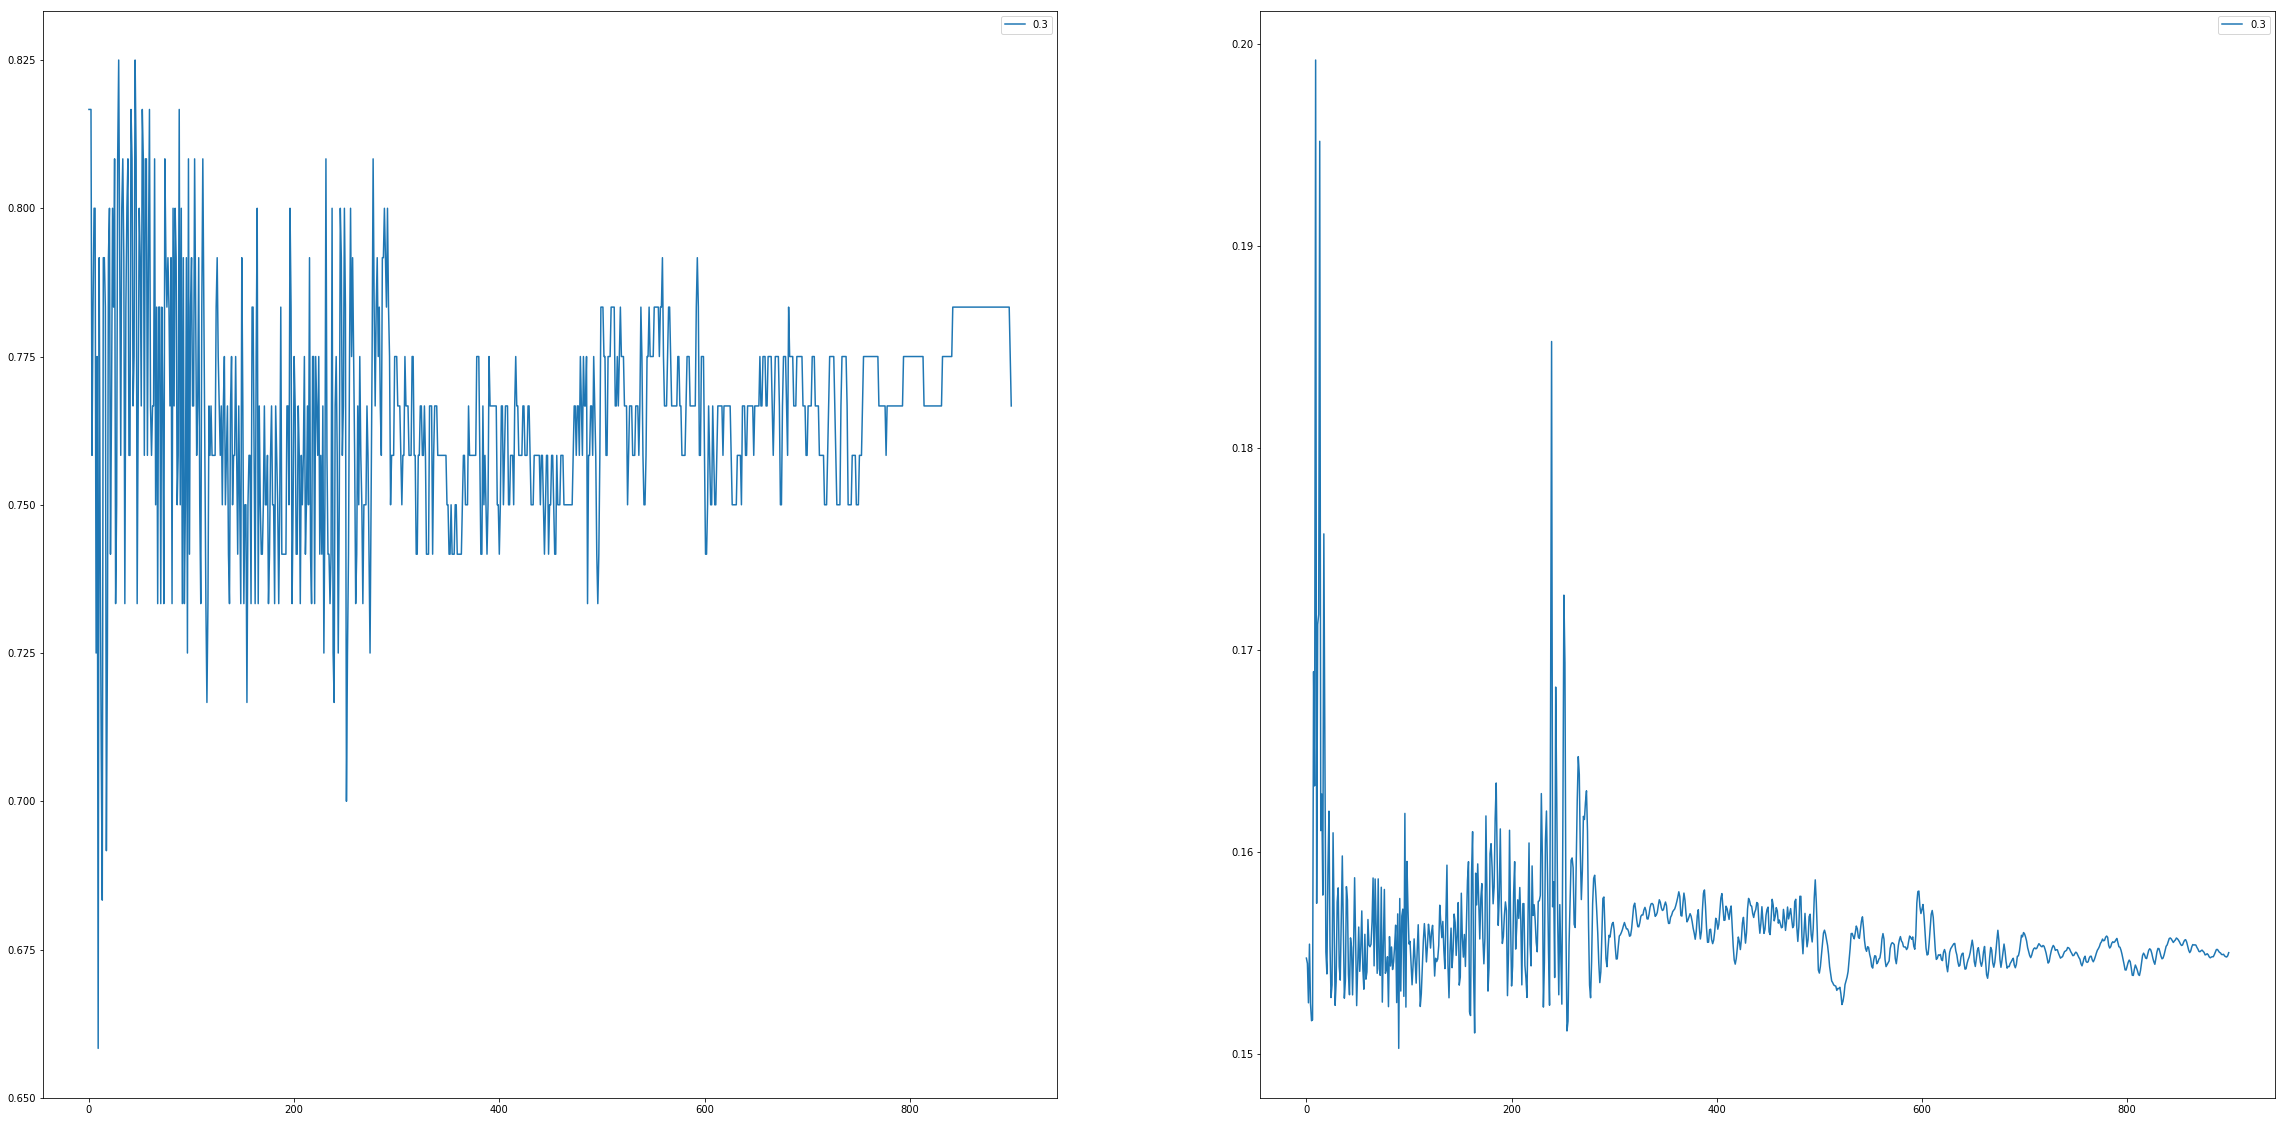

In [421]:
# multiplier no-grad Adam

_, axes = plt.subplots(1,2,figsize=(40,20))
reg_show = [0.3]
for key in reg_show:
    axes[0].plot(loss_hist[key]['acc'][100:], label=str(key))
    axes[1].plot(loss_hist[key]['val'][100:], label=str(key))

axes[0].legend()
axes[1].legend()

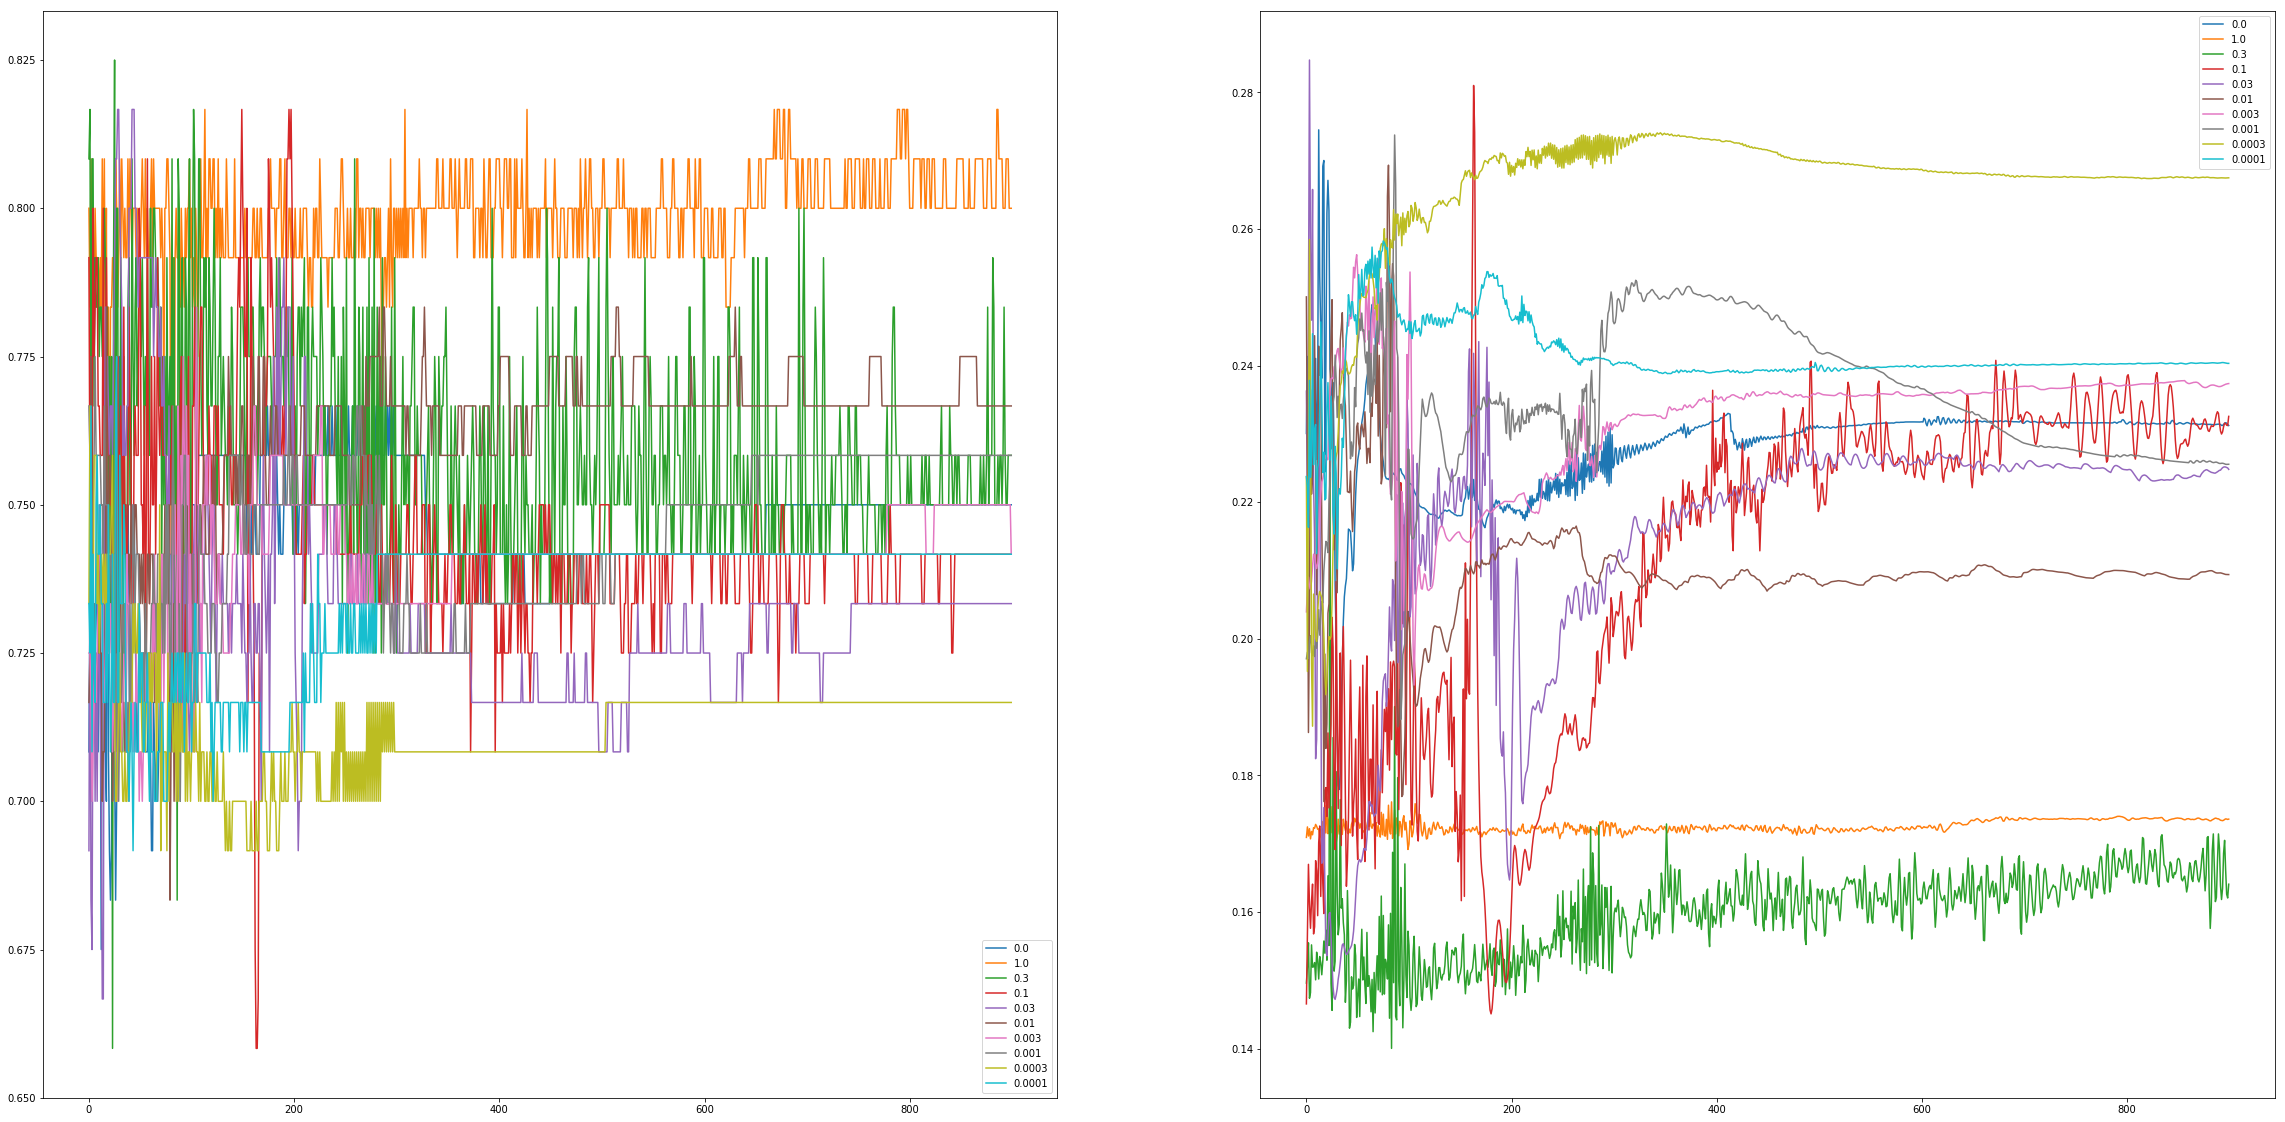

In [410]:
# No multiplier Adam

_, axes = plt.subplots(1,2,figsize=(40,20))
reg_show = reg_candidate
for key in reg_show:
    axes[0].plot(loss_hist[key]['acc'][100:], label=str(key))
    axes[1].plot(loss_hist[key]['val'][100:], label=str(key))

axes[0].legend()
axes[1].legend()

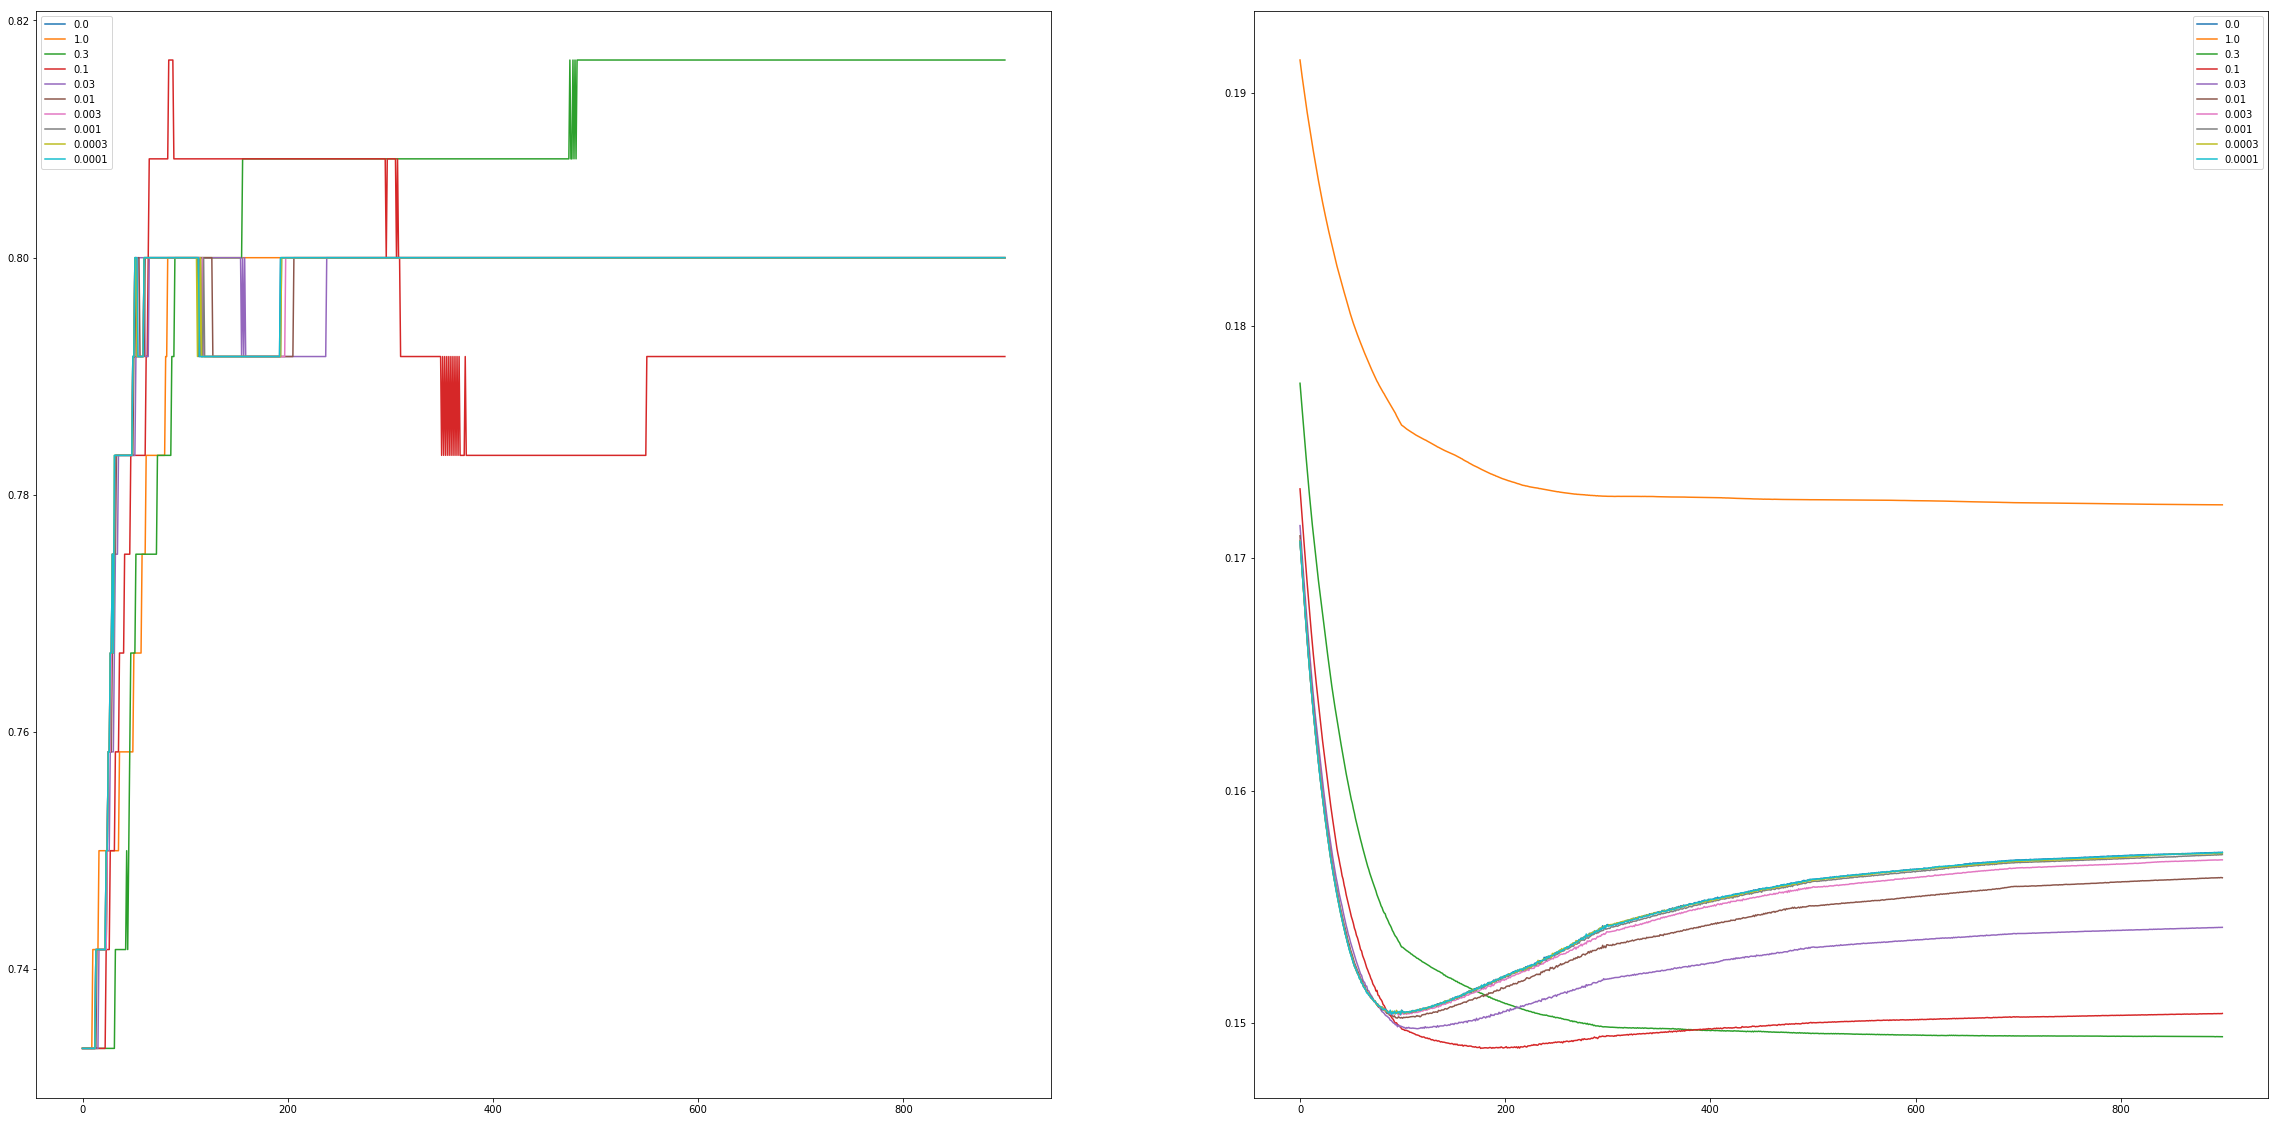

In [401]:
# No multiplier

_, axes = plt.subplots(1,2,figsize=(40,20))
reg_show = reg_candidate
for key in reg_show:
    axes[0].plot(loss_hist[key]['acc'][100:], label=str(key))
    axes[1].plot(loss_hist[key]['val'][100:], label=str(key))

axes[0].legend()
axes[1].legend()

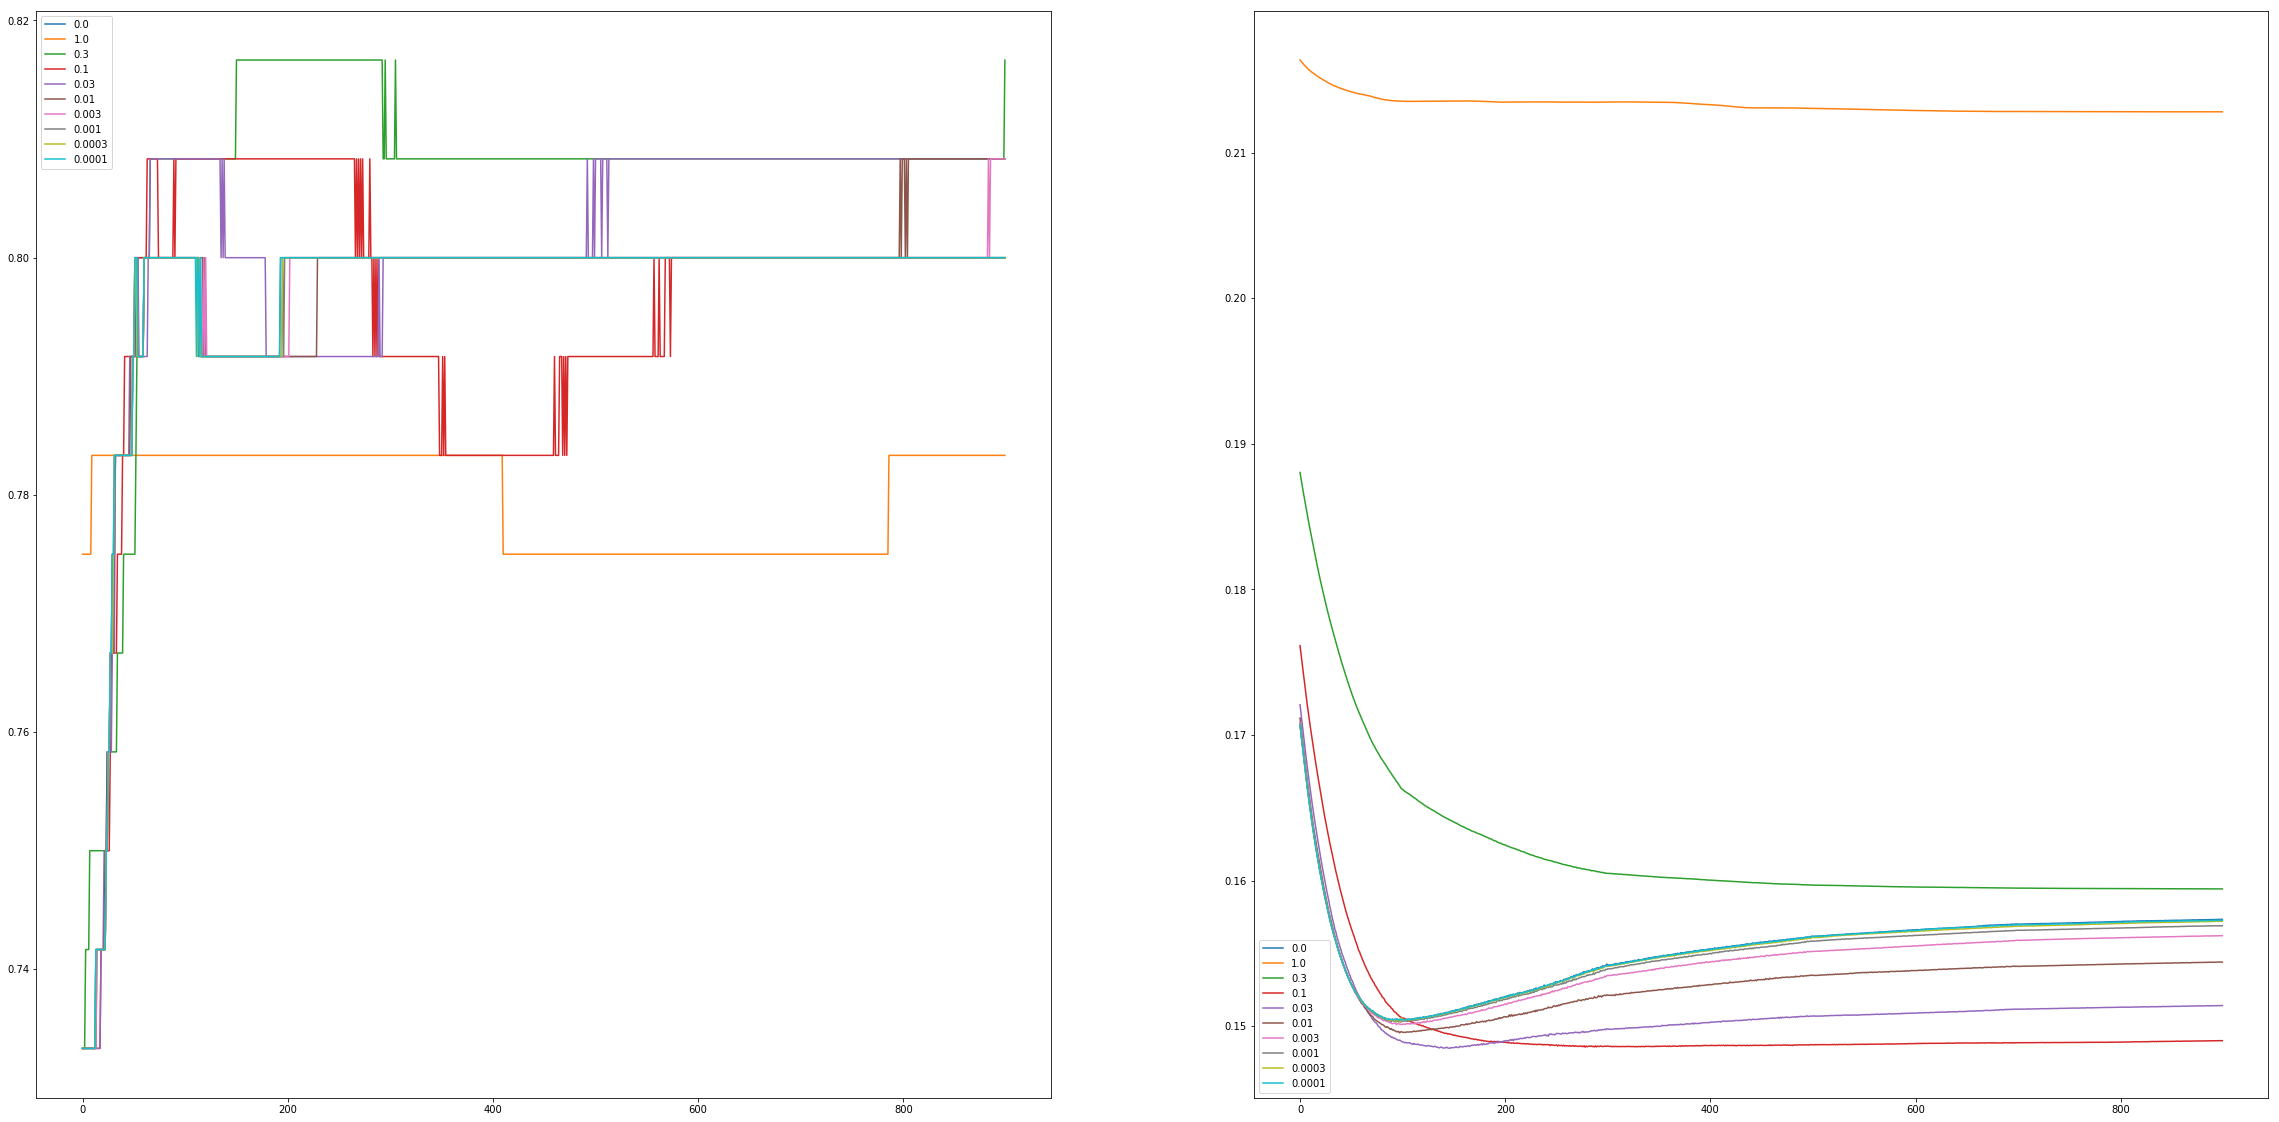

In [399]:
# Multiplier with grads

_, axes = plt.subplots(1,2,figsize=(40,20))
reg_show = reg_candidate
for key in reg_show:
    axes[0].plot(loss_hist[key]['acc'][100:], label=str(key))
    axes[1].plot(loss_hist[key]['val'][100:], label=str(key))

axes[0].legend()
axes[1].legend()

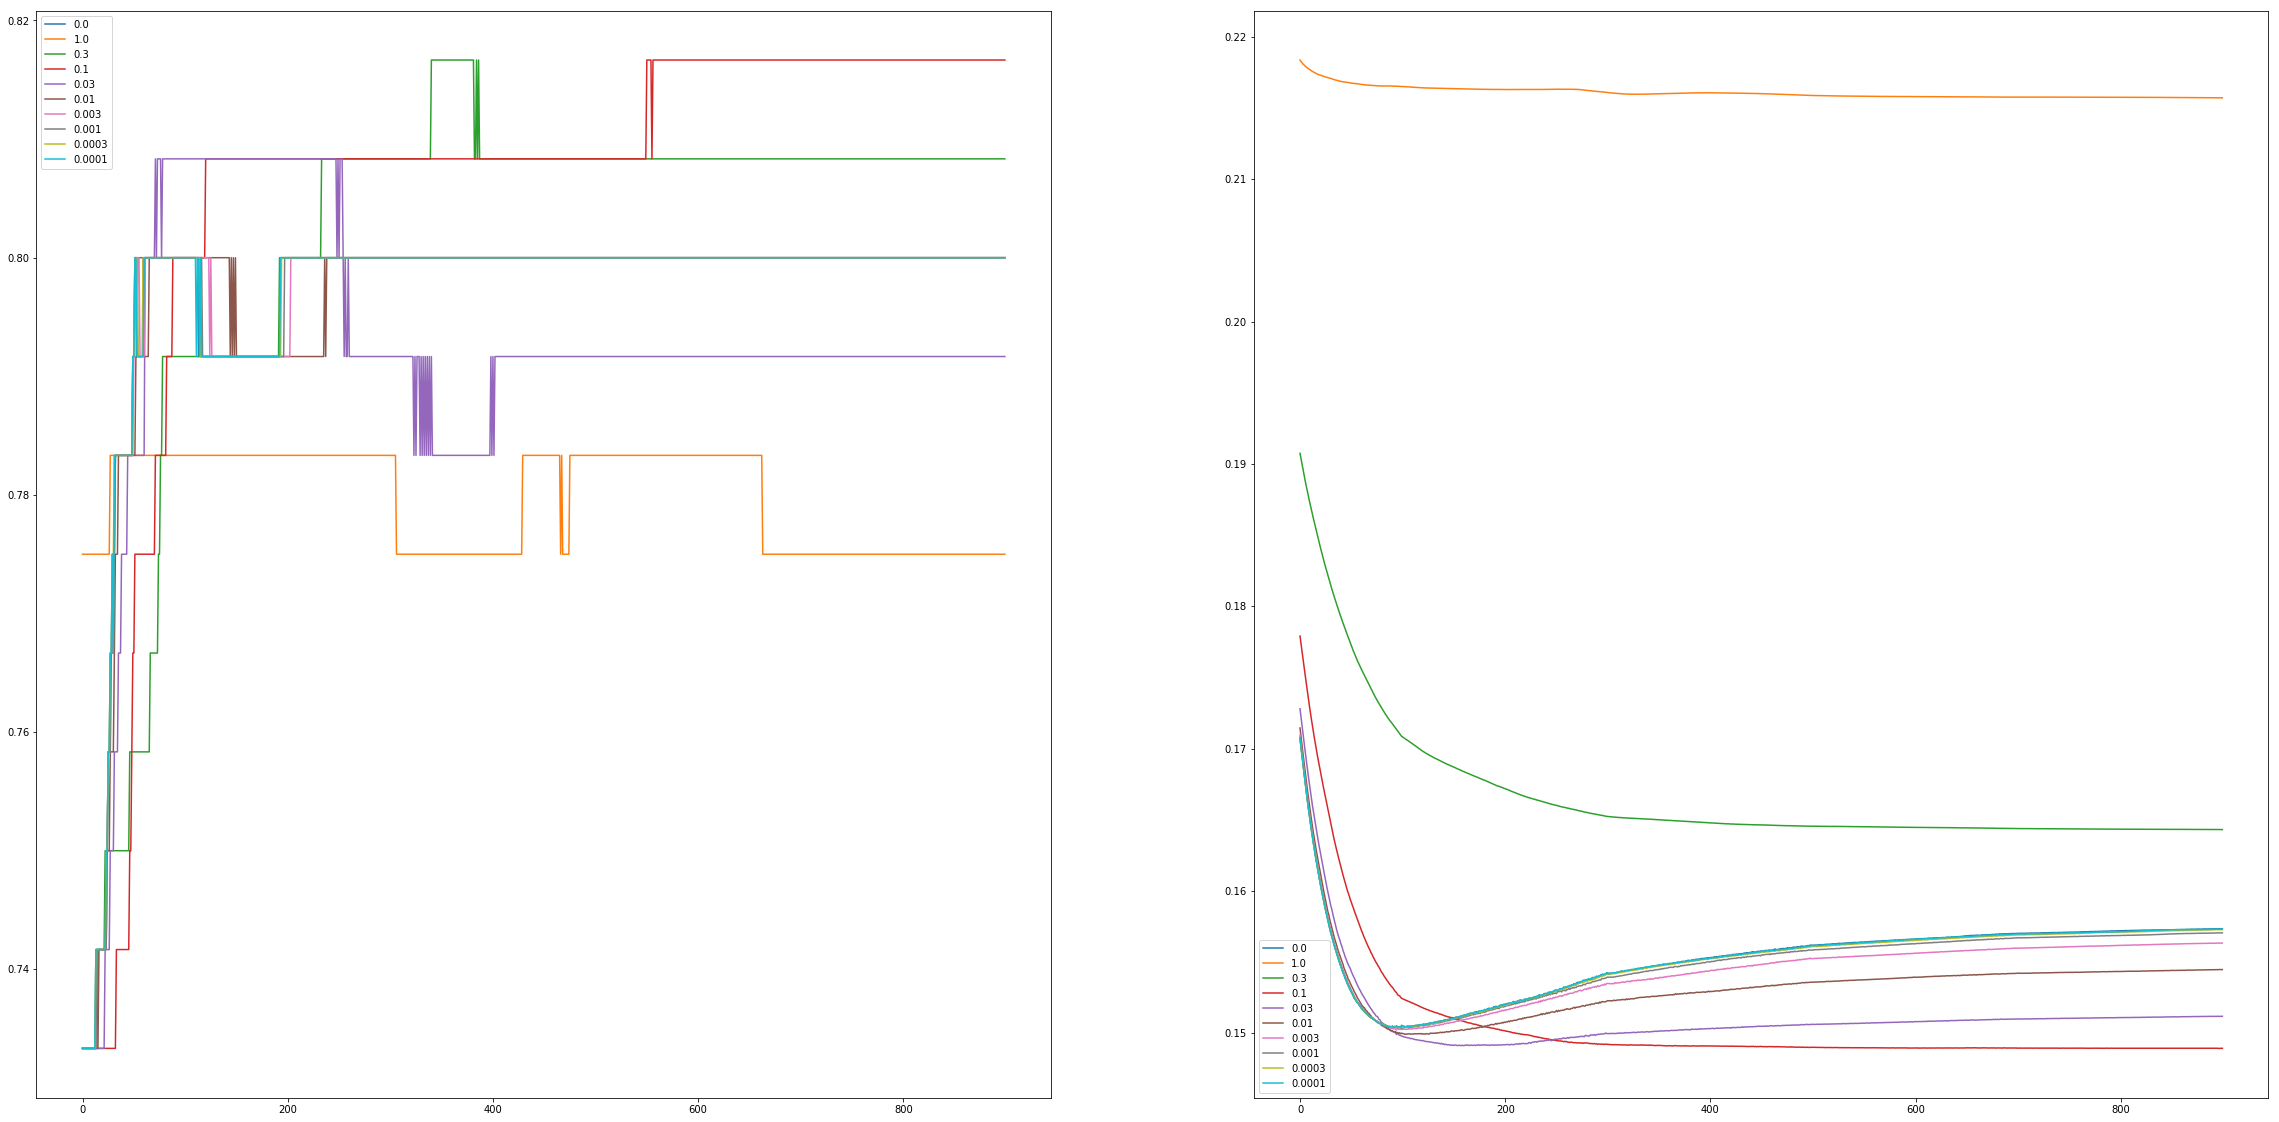

In [397]:
# Multiplier no grads

_, axes = plt.subplots(1,2,figsize=(40,20))
reg_show = reg_candidate
for key in reg_show:
    axes[0].plot(loss_hist[key]['acc'][100:], label=str(key))
    axes[1].plot(loss_hist[key]['val'][100:], label=str(key))

axes[0].legend()
axes[1].legend()

# MNIST

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, ReLU, Activation
import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline

In [2]:
from tensorflow.keras.datasets import mnist
from tensorflow import keras
from tensorflow.keras.utils import to_categorical

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession



config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
import pickle

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [5]:
x_train = x_train.reshape([-1,28,28,1])
x_test = x_test.reshape([-1,28,28,1])

In [6]:
idx = np.argsort(y_train)
x_train = x_train[idx]
y_train = y_train[idx]

In [7]:
idxs_per_class = [np.squeeze(np.argwhere(y_train == i)) for i in range(10)]

In [8]:
train_size_per_class = 200
val_size_per_class = 5000

x_train_small = []
y_train_small = []

x_val = []
y_val = []

np.random.seed(666)

for i in range(10):
    perm_idx = np.random.permutation(len(idxs_per_class[i]))
    x_train_small.extend(x_train[idxs_per_class[i][perm_idx[:train_size_per_class]]])
    x_val.extend(x_train[idxs_per_class[i][perm_idx[train_size_per_class:train_size_per_class + val_size_per_class]]])
    y_train_small.extend(y_train[idxs_per_class[i][perm_idx[:train_size_per_class]]])
    y_val.extend(y_train[idxs_per_class[i][perm_idx[train_size_per_class:train_size_per_class + val_size_per_class]]])
    
x_train_small = np.array(x_train_small)
x_val = np.array(x_val)


In [9]:
x_train_small.shape, y_train.shape

((2000, 28, 28, 1), (60000,))

In [10]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(
            featurewise_center = True,
            featurewise_std_normalization = True,
            horizontal_flip=True,)

val_datagen = keras.preprocessing.image.ImageDataGenerator(
    featurewise_center = True,
    featurewise_std_normalization = True)

In [11]:
train_datagen.fit(x_train_small)
val_datagen.mean = train_datagen.mean
val_datagen.std = train_datagen.std

In [12]:
train_gen = train_datagen.flow(x_train_small, to_categorical(y_train_small), batch_size=32)
val_gen = val_datagen.flow(x_val, to_categorical(y_val), shuffle=False, batch_size=32)

In [13]:
to_categorical(y_train_small).shape

(2000, 10)

In [14]:
np.unique(y_val)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [16]:
# Setup model
tf.keras.backend.clear_session()


# class CNNBlock(tf.keras.Model):

#     def __init__(self):
#         super(MLPBlock, self).__init__()
#         self.conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1))
#         self.pool1 = tf.keras.layers.MaxPooling2D((2, 2))
#         self.conv2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')
#         self.pool2 = tf.keras.layers.MaxPooling2D((2, 2))
#         self.conv3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')
#         self.flatten = tf.keras.layers.Flatten()
#         self.dense1 = tf.keras.layers.Dense(64, activation='relu')
#         self.dense2 = tf.keras.layers.Dense(10)
#         self.softmax = tf.keras.layers.Activation('softmax')
        
#         self.logits = None
#         self.probs = None

#     def call(self, inputs):
#         x = self.conv1(inputs)
#         x = self.pool1(x)
#         x = self.conv2(x)
#         x = self.pool2(x)
#         x = self.conv3(x)
#         x = self.flatten(x)
#         x = self.dense1(x)
#         self.logits = self.dense2(x)
#         self.probs = self.softmax(x)
#         return self.probs


model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(10))
# model.add(tf.keras.layers.Activation('softmax'))

model_with_softmax = tf.keras.models.Model(model.input, tf.keras.layers.Activation('softmax')(model.output))

init_weight_copy = model.get_weights()

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                3

In [17]:
model_with_softmax.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [51]:
a = tf.Variable([[2.,3.]])
b = tf.constant([[1.,2.],[4.,1.]])

with tf.GradientTape() as tape:
    c = tf.matmul(a,b)
    
tape.batch_jacobian(c,a)

<tf.Tensor: id=21071830, shape=(1, 2, 2), dtype=float32, numpy=
array([[[1., 4.],
        [2., 1.]]], dtype=float32)>

In [48]:
c

<tf.Tensor: id=21071226, shape=(2, 1), dtype=float32, numpy=
array([[ 8.],
       [11.]], dtype=float32)>

In [56]:
@tf.function()
def double_back(x, y, lamb):
    with tf.GradientTape() as tape1:
        with tf.GradientTape() as tape2:
            tape2.watch(x)
            p = model_with_softmax(x)
#             print(p)
            error = tf.losses.categorical_crossentropy(y, p)
        grad_Lx = tape2.gradient(error, x)
#         print(error)
        loss = error + lamb * tf.reduce_mean(tf.reduce_sum(grad_Lx ** 2, axis=[1,2,3]))
    grads = tape1.gradient(loss, model.trainable_variables)
    
    return grads, loss, grad_Lx

@tf.function()
def JacReg(x, y, lamb):
    with tf.GradientTape() as tape1:
        with tf.GradientTape() as tape2:
            tape2.watch(x)
            p = model_with_softmax(x)
            error = tf.losses.categorical_crossentropy(y, p)
        grad_fx = tape2.batch_jacobian(p, x)
        loss = error + lamb * tf.reduce_sum(grad_fx ** 2) / tf.cast(tf.shape(y)[0], tf.float32)
    grads = tape1.gradient(loss, model.trainable_variables)
    
    return grads, loss, grad_fx

@tf.function()
def FobReg(x, y, lamb):
    with tf.GradientTape() as tape1:
        with tf.GradientTape() as tape2:
            tape2.watch(x)
            logit = model(x)
            error = tf.losses.categorical_crossentropy(y, tf.nn.softmax(logit))
        grad_gx = tape2.batch_jacobian(logit, x)
        loss = error + lamb * tf.reduce_sum(grad_gx ** 2) / tf.cast(tf.shape(y)[0], tf.float32)
    grads = tape1.gradient(loss, model.trainable_variables)
    
    return grads, loss, grad_gx

@tf.function()
def MyFobReg2(x, y, lamb):
    with tf.GradientTape() as tape1:
        with tf.GradientTape() as tape2:
            tape2.watch(x)
            logit = model(x)
            p = tf.nn.softmax(logit)
            error = tf.losses.categorical_crossentropy(y, p)
            
        # tr(g_x^T L^2g g_x)
#         grad_gx = tf.reshape(tape2.gradient(logit, x), [-1,10,28*28*1])
        grad_gx = tape2.batch_jacobian(logit, x)
        grad_gx = tf.reshape(grad_gx, [-1,10,28*28*1])
        
        L_2g = tf.stop_gradient(tf.linalg.diag(p) - tf.matmul(tf.reshape(p,[-1,10,1]) , tf.reshape(p,[-1,1,10])))
        tmp = tf.matmul(tf.transpose(grad_gx, perm=[0,2,1]), L_2g)
        # To increase efficiency
        penalty = tf.reduce_sum(tmp * tf.transpose(grad_gx, perm=[0,2,1])) / tf.cast(tf.shape(y)[0], tf.float32)
        
        
        loss = error + lamb * penalty
    grads = tape1.gradient(loss, model.trainable_variables)
    
    return grads, loss, grad_gx

@tf.function()
def MyFobReg1(x, y, lamb):
    with tf.GradientTape() as tape1:
        with tf.GradientTape() as tape2:
            tape2.watch(x)
            logit = model(x)
            p = tf.nn.softmax(logit)
            error = tf.losses.categorical_crossentropy(y, p)
            
        # tr(g_x^T L^2g g_x)
        grad_gx = tf.reshape(tape2.gradient(logit, x), [-1,10,28*28*1])
        L_2g = tf.linalg.diag(p) - tf.matmul(p, tf.transpose(p))
        tmp = tf.matmul(tf.transpose(grad_gx, [0,2,1]), L_2g)
        # To increase efficiency
        penalty = tf.reduce_sum(tmp * tf.transpose(grad_gx)) / tf.cast(tf.shape(y)[0], tf.float32)
        
        
        loss = error + lamb * penalty
    grads = tape1.gradient(loss, model.trainable_variables)
    
    return grads, loss, grad_gx

In [57]:
iters = 1000
reg_candidate = [1., 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001, 0.00003, 0.00001]
# reg_candidate = [0.]
loss_hist_db = {
}

epochs = 50
batch_size = 32

x_in = tf.constant(1.)

for reg in reg_candidate:
    
    loss_hist_db[reg] = {
        'train':[],
        'val':[],
        'acc':[],
        'final_val':None
        'final_acc':None
        
    }
    
    lr = 0.001
    model.set_weights(init_weight_copy)

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    
    for i in range(epochs):
        batches = 0
        for x_batch, y_batch in train_gen:
            x_batch = x_in * x_batch
            grads, loss, grad_fx = double_back(x_batch, y_batch, reg)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            
            batches += 1 
            if batches > len(x_train_small) / batch_size:
                break
                
        result_train = model_with_softmax.evaluate_generator(train_gen)
        result_val = model_with_softmax.evaluate_generator(val_gen)
        loss_hist_db[reg]['train'].append(result_train[0])
        loss_hist_db[reg]['val'].append(result_val[0])
        loss_hist_db[reg]['acc'].append(result_val[1])
        print(result_val)
        
    loss_hist_db[reg]['final_val'] = result_val[0]
    loss_hist_db[reg]['final_acc'] = result_val[1]
    
    
                
            
    
#     for i in range(1, iters+1):
#         input_X = tf.Variable(X_train)
#         double_back(input_X, )
#         grads = tape1.gradient(loss, model.trainable_variables)
#         optimizer.apply_gradients(zip(grads, model.trainable_variables))
#         y_pred_all = model(X_test)
#         eval_loss = loss_fn(y_pred_all, y_test.reshape([-1,1]))

#         eval_acc = np.mean(1 - np.abs(np.rint(y_pred_all) - y_test.reshape([-1,1])))
#         loss_hist_db[reg]['train'].append(loss)
#         loss_hist_db[reg]['val'].append(eval_loss)odel(x)
#             error = tf.losses.categorical_crossentropy(p, y)
#         loss_hist_db[reg]['acc'].append(eval_acc)


#         if i % 200 == 0:
#             optimizer.lr = optimizer.lr/2

#         if i % 200 == 0:

#             print(f'training loss: epoch {i} = {loss}')
#             print(f'evaluation loss: epoch {i} = {eval_loss}')
#             print(f'evaluation acc: epoch {i} = {eval_acc}')



[0.746499462130641, 0.75264]
[0.6005633767361748, 0.79784]
[0.4009205850189217, 0.87824]
[0.4007048101372354, 0.87154]
[0.3049769011797307, 0.90332]
[0.2738811289998855, 0.91368]
[0.24781229706947058, 0.9204]
[0.2655669342977026, 0.91206]
[0.2214938226608489, 0.92886]
[0.20886568764223307, 0.9349]
[0.19682387843694846, 0.93854]
[0.1993763892223459, 0.93662]
[0.17919777970784448, 0.94522]
[0.19298858505529806, 0.93896]
[0.17414223125260642, 0.9481]
[0.2186644164549207, 0.9337]
[0.16019511903638095, 0.95146]
[0.19374250115815964, 0.94258]
[0.18303367538341594, 0.94468]
[0.15188389102809094, 0.95338]
[0.1902173865704182, 0.9439]
[0.2019325049560118, 0.94172]
[0.179598671971893, 0.9465]
[0.1811991250142455, 0.94604]
[0.18557117185638633, 0.94622]
[0.18750913444028255, 0.94512]
[0.1617771158729184, 0.95362]
[0.20172862952515652, 0.9423]
[0.15513036615117093, 0.95322]
[0.18875945067083894, 0.94624]
[0.2009257227032284, 0.94584]


KeyboardInterrupt: 

In [ ]:
iters = 1000
reg_candidate = [1., 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001, 0.00003, 0.00001]
# reg_candidate = [0.]
loss_hist_jac = {
}

epochs = 50
batch_size = 32

x_in = tf.constant(1.)

for reg in reg_candidate:
    
    loss_hist_jac[reg] = {
        'train':[],
        'val':[],
        'acc':[],
        'final_val':None
        'final_acc':None
        
    }
    
    lr = 0.001
    model.set_weights(init_weight_copy)

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    
    for i in range(epochs):
        batches = 0
        for x_batch, y_batch in train_gen:
            x_batch = x_in * x_batch
            grads, loss, grad_fx = double_back(x_batch, y_batch, reg)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            
            batches += 1 
            if batches > len(x_train_small) / batch_size:
                break
                
        result_train = model_with_softmax.evaluate_generator(train_gen)
        result_val = model_with_softmax.evaluate_generator(val_gen)
        loss_hist_jac[reg]['train'].append(result_train[0])
        loss_hist_jac[reg]['val'].append(result_val[0])
        loss_hist_jac[reg]['acc'].append(result_val[1])
        print(result_val)
        
    loss_hist_jac[reg]['final_val'] = result_val[0]
    loss_hist_jac[reg]['final_acc'] = result_val[1]
    
    
                
            
    
#     for i in range(1, iters+1):
#         input_X = tf.Variable(X_train)
#         double_back(input_X, )
#         grads = tape1.gradient(loss, model.trainable_variables)
#         optimizer.apply_gradients(zip(grads, model.trainable_variables))
#         y_pred_all = model(X_test)
#         eval_loss = loss_fn(y_pred_all, y_test.reshape([-1,1]))

#         eval_acc = np.mean(1 - np.abs(np.rint(y_pred_all) - y_test.reshape([-1,1])))
#         loss_hist_jac[reg]['train'].append(loss)
#         loss_hist_jac[reg]['val'].append(eval_loss)odel(x)
#             error = tf.losses.categorical_crossentropy(p, y)
#         loss_hist_jac[reg]['acc'].append(eval_acc)


#         if i % 200 == 0:
#             optimizer.lr = optimizer.lr/2

#         if i % 200 == 0:

#             print(f'training loss: epoch {i} = {loss}')
#             print(f'evaluation loss: epoch {i} = {eval_loss}')
#             print(f'evaluation acc: epoch {i} = {eval_acc}')



In [ ]:
iters = 1000
reg_candidate = [1., 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001, 0.00003, 0.00001]
# reg_candidate = [0.]
loss_hist_fob = {
}

epochs = 50
batch_size = 32

x_in = tf.constant(1.)

for reg in reg_candidate:
    
    loss_hist_fob[reg] = {
        'train':[],
        'val':[],
        'acc':[],
        'final_val':None
        'final_acc':None
        
    }
    
    lr = 0.001
    model.set_weights(init_weight_copy)

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    
    for i in range(epochs):
        batches = 0
        for x_batch, y_batch in train_gen:
            x_batch = x_in * x_batch
            grads, loss, grad_fx = double_back(x_batch, y_batch, reg)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            
            batches += 1 
            if batches > len(x_train_small) / batch_size:
                break
                
        result_train = model_with_softmax.evaluate_generator(train_gen)
        result_val = model_with_softmax.evaluate_generator(val_gen)
        loss_hist_fob[reg]['train'].append(result_train[0])
        loss_hist_fob[reg]['val'].append(result_val[0])
        loss_hist_fob[reg]['acc'].append(result_val[1])
        print(result_val)
        
    loss_hist_fob[reg]['final_val'] = result_val[0]
    loss_hist_fob[reg]['final_acc'] = result_val[1]
    
    
                
            
    
#     for i in range(1, iters+1):
#         input_X = tf.Variable(X_train)
#         double_back(input_X, )
#         grads = tape1.gradient(loss, model.trainable_variables)
#         optimizer.apply_gradients(zip(grads, model.trainable_variables))
#         y_pred_all = model(X_test)
#         eval_loss = loss_fn(y_pred_all, y_test.reshape([-1,1]))

#         eval_acc = np.mean(1 - np.abs(np.rint(y_pred_all) - y_test.reshape([-1,1])))
#         loss_hist_fob[reg]['train'].append(loss)
#         loss_hist_fob[reg]['val'].append(eval_loss)odel(x)
#             error = tf.losses.categorical_crossentropy(p, y)
#         loss_hist_fob[reg]['acc'].append(eval_acc)


#         if i % 200 == 0:
#             optimizer.lr = optimizer.lr/2

#         if i % 200 == 0:

#             print(f'training loss: epoch {i} = {loss}')
#             print(f'evaluation loss: epoch {i} = {eval_loss}')
#             print(f'evaluation acc: epoch {i} = {eval_acc}')



In [ ]:
iters = 1000
reg_candidate = [1., 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001, 0.00003, 0.00001]
# reg_candidate = [0.]
loss_hist_myfob = {
}

epochs = 50
batch_size = 32

x_in = tf.constant(1.)

for reg in reg_candidate:
    
    loss_hist_myfob[reg] = {
        'train':[],
        'val':[],
        'acc':[],
        'final_val':None
        'final_acc':None
        
    }
    
    lr = 0.001
    model.set_weights(init_weight_copy)

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    
    for i in range(epochs):
        batches = 0
        for x_batch, y_batch in train_gen:
            x_batch = x_in * x_batch
            grads, loss, grad_fx = double_back(x_batch, y_batch, reg)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            
            batches += 1 
            if batches > len(x_train_small) / batch_size:
                break
                
        result_train = model_with_softmax.evaluate_generator(train_gen)
        result_val = model_with_softmax.evaluate_generator(val_gen)
        loss_hist_myfob[reg]['train'].append(result_train[0])
        loss_hist_myfob[reg]['val'].append(result_val[0])
        loss_hist_myfob[reg]['acc'].append(result_val[1])
        print(result_val)
        
    loss_hist_myfob[reg]['final_val'] = result_val[0]
    loss_hist_myfob[reg]['final_acc'] = result_val[1]
    
    
                
            
    
#     for i in range(1, iters+1):
#         input_X = tf.Variable(X_train)
#         double_back(input_X, )
#         grads = tape1.gradient(loss, model.trainable_variables)
#         optimizer.apply_gradients(zip(grads, model.trainable_variables))
#         y_pred_all = model(X_test)
#         eval_loss = loss_fn(y_pred_all, y_test.reshape([-1,1]))

#         eval_acc = np.mean(1 - np.abs(np.rint(y_pred_all) - y_test.reshape([-1,1])))
#         loss_hist_myfob[reg]['train'].append(loss)
#         loss_hist_myfob[reg]['val'].append(eval_loss)odel(x)
#             error = tf.losses.categorical_crossentropy(p, y)
#         loss_hist_myfob[reg]['acc'].append(eval_acc)


#         if i % 200 == 0:
#             optimizer.lr = optimizer.lr/2

#         if i % 200 == 0:

#             print(f'training loss: epoch {i} = {loss}')
#             print(f'evaluation loss: epoch {i} = {eval_loss}')
#             print(f'evaluation acc: epoch {i} = {eval_acc}')



In [36]:
with open('data/loss_hist_db.pk', 'wb') as f:
    pickle.dump(loss_hist_db, f)
    
with open('data/loss_hist_jac.pk', 'wb') as f:
    pickle.dump(loss_hist_jac, f)
    
with open('data/loss_hist_fob.pk', 'wb') as f:
    pickle.dump(loss_hist_fob, f)
    
with open('data/loss_hist_myfob.pk', 'wb') as f:
    pickle.dump(loss_hist_myfob, f)

In [47]:
iters = 1000
reg_candidate = [1., 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001, 0.00003, 0.00001]
# reg_candidate = [0.003]
loss_hist_NI = {
}

epochs = 50
batch_size = 32

x_in = tf.constant(1.)

for reg in reg_candidate:
    
    loss_hist_NI[reg] = {
        'train':[],
        'val':[],
        'acc':[]
        
    }
    
    lr = 0.001
    model.set_weights(init_weight_copy)

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    
    for i in range(epochs):
        batches = 0
        for x_batch, y_batch in train_gen:
#             print(x_batch.shape)
            x_batch = x_batch + reg * np.random.normal(size=x_batch.shape)
#             print( np.random.normal(x_batch.shape).shape)
#             print(x_batch.shape)
            
            model_with_softmax.fit(x_batch, y_batch, verbose=0)
            
            batches += 1 
            if batches > len(x_train_small) / batch_size:
                break
                
        result_train = model_with_softmax.evaluate_generator(train_gen)
        result_val = model_with_softmax.evaluate_generator(val_gen)
        loss_hist_NI[reg]['train'] = result_train[0]
        loss_hist_NI[reg]['val'] = result_val[0]
        loss_hist_NI[reg]['acc'] = result_val[1]
        print(result_val)
                


[0.9575983398782848, 0.68792]
[0.6819717064523689, 0.766]
[0.485984924501398, 0.84096]
[0.432115811329652, 0.85624]
[0.37554370698245554, 0.87654]
[0.36781318141384345, 0.87954]
[0.3180139635396694, 0.89748]
[0.31513749434709815, 0.90298]
[0.28664030402857676, 0.90968]
[0.28183041547199933, 0.91214]
[0.22597850541264963, 0.93048]
[0.2341477004983966, 0.92798]
[0.2731987765567289, 0.91566]
[0.23112219552419846, 0.9296]
[0.2353594795059389, 0.93086]
[0.22413934492366341, 0.9342]
[0.2563915043559861, 0.9258]
[0.20962289180690025, 0.93898]
[0.2515108604863657, 0.92798]
[0.2542045575108563, 0.93276]
[0.21265504346389272, 0.93904]
[0.19797949032450765, 0.94464]
[0.22229638487075776, 0.9433]
[0.2346492373869953, 0.93298]
[0.21258171770675016, 0.94518]
[0.23327067755273298, 0.94234]
[0.2218681665788967, 0.945]
[0.24469372909886644, 0.93506]
[0.2381495398292598, 0.93894]
[0.2495689620872753, 0.93744]
[0.245664247662319, 0.93836]
[0.22849362751119195, 0.94416]
[0.23470006627006232, 0.94348]
[0.2

[0.2713060869466018, 0.95042]
[0.2882722546584659, 0.9467]
[0.294956057954567, 0.94408]
[0.25569477314584904, 0.94778]
[0.2935289505400566, 0.94338]
[0.30592882550898576, 0.93892]
[0.24437050698365767, 0.94358]
[0.2821315890327, 0.94288]
[0.33092812611859046, 0.93906]
[0.35707634111703324, 0.93402]
[0.26362342728340393, 0.9437]
[0.21710687726874803, 0.94824]
[0.233299326840332, 0.94978]
[0.21576305052919217, 0.95204]
[0.20949210579226946, 0.95546]
[0.2185362609559435, 0.9551]
[0.21784128305649356, 0.95682]
[0.21985353226256155, 0.95736]
[0.22269157622915484, 0.95726]
[0.22513416217439522, 0.95728]
[0.22749651595264503, 0.95732]
[0.23331183648648696, 0.95676]
[0.2342640721649736, 0.957]
[0.23586902230855444, 0.95706]
[0.23842123887249092, 0.95692]
[0.2406086065607683, 0.95688]
[0.24176098128981607, 0.95696]
[0.24352220429757765, 0.9569]
[0.5718706372031324, 0.8056]
[0.4074923327721188, 0.86918]
[0.3754940056641272, 0.87868]
[0.28575496699706304, 0.91006]
[0.2571558009446387, 0.92]
[0.30

[0.3190968188305, 0.94774]
[0.3194762496808363, 0.9478]
[0.32044662873057206, 0.94792]
[0.3236339511407987, 0.94756]
[0.32579246630608477, 0.9474]
[0.3279854634709209, 0.9474]


In [48]:
for reg in [0.]:
    
    loss_hist_NI[reg] = {
        'train':[],
        'val':[],
        'acc':[]
        
    }
    
    lr = 0.001
    model.set_weights(init_weight_copy)

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    
    for i in range(epochs):
        batches = 0
        for x_batch, y_batch in train_gen:
#             print(x_batch.shape)
            x_batch = x_batch + reg * np.random.normal(size=x_batch.shape)
#             print( np.random.normal(x_batch.shape).shape)
#             print(x_batch.shape)
            
            model_with_softmax.fit(x_batch, y_batch, verbose=0)
            
            batches += 1 
            if batches > len(x_train_small) / batch_size:
                break
                
        result_train = model_with_softmax.evaluate_generator(train_gen)
        result_val = model_with_softmax.evaluate_generator(val_gen)
        loss_hist_NI[reg]['train'] = result_train[0]
        loss_hist_NI[reg]['val'] = result_val[0]
        loss_hist_NI[reg]['acc'] = result_val[1]
        print(result_val)

[0.5943980531496492, 0.80368]
[0.4165476177927742, 0.8634]
[0.34162452423489836, 0.89362]
[0.31187586444584975, 0.90098]
[0.2593405174480217, 0.92156]
[0.2736474612785261, 0.91636]
[0.21160449289536684, 0.93642]
[0.2657346436382949, 0.92318]
[0.251892487984672, 0.93086]
[0.23655512724221092, 0.94034]
[0.2440671042685412, 0.93762]
[0.22683821646059196, 0.9438]
[0.2439773485723885, 0.9379]
[0.2432705224391338, 0.94402]
[0.2877403126148107, 0.93442]
[0.23057487300294593, 0.9477]
[0.2414171618838433, 0.94702]
[0.2609881692994715, 0.94502]
[0.2688057793021463, 0.94512]
[0.27978697091512694, 0.94422]
[0.2576327885648328, 0.94884]
[0.26834109682992763, 0.9476]
[0.2669322908773106, 0.94868]
[0.2722029094633559, 0.94858]
[0.2759532054677842, 0.94858]
[0.28019230847919024, 0.94882]
[0.2834048615750051, 0.94866]
[0.28605146895797035, 0.9486]
[0.28775443780099275, 0.94854]
[0.2899475754296346, 0.94876]
[0.291927316427235, 0.94892]
[0.29303810809467984, 0.94912]
[0.29646264263845135, 0.94888]
[0.29

In [49]:
loss_hist_NI

{1.0: {'train': 0.005414344506991458,
  'val': 0.21190556799334964,
  'acc': 0.95038},
 0.3: {'train': 0.0038005214045413248,
  'val': 0.28611341956785297,
  'acc': 0.9465},
 0.1: {'train': 5.673741811950181e-05,
  'val': 0.27801285764644934,
  'acc': 0.95252},
 0.03: {'train': 0.00012047812930494916,
  'val': 0.26753017737789947,
  'acc': 0.95274},
 0.01: {'train': 5.6725102427980536e-05,
  'val': 0.2773083255480223,
  'acc': 0.95306},
 0.003: {'train': 9.307076047409484e-05,
  'val': 0.24352220429757765,
  'acc': 0.9569},
 0.001: {'train': 9.841145836415105e-05,
  'val': 0.2752783302059901,
  'acc': 0.95314},
 0.0003: {'train': 6.0657484323561974e-05,
  'val': 0.2762101289338944,
  'acc': 0.9544},
 0.0001: {'train': 7.770753978865474e-05,
  'val': 0.3280434977424409,
  'acc': 0.94906},
 3e-05: {'train': 6.735654053391911e-05,
  'val': 0.3147184435711912,
  'acc': 0.9496},
 1e-05: {'train': 7.441567624251576e-05,
  'val': 0.3279854634709209,
  'acc': 0.9474},
 0.0: {'train': 5.1867799

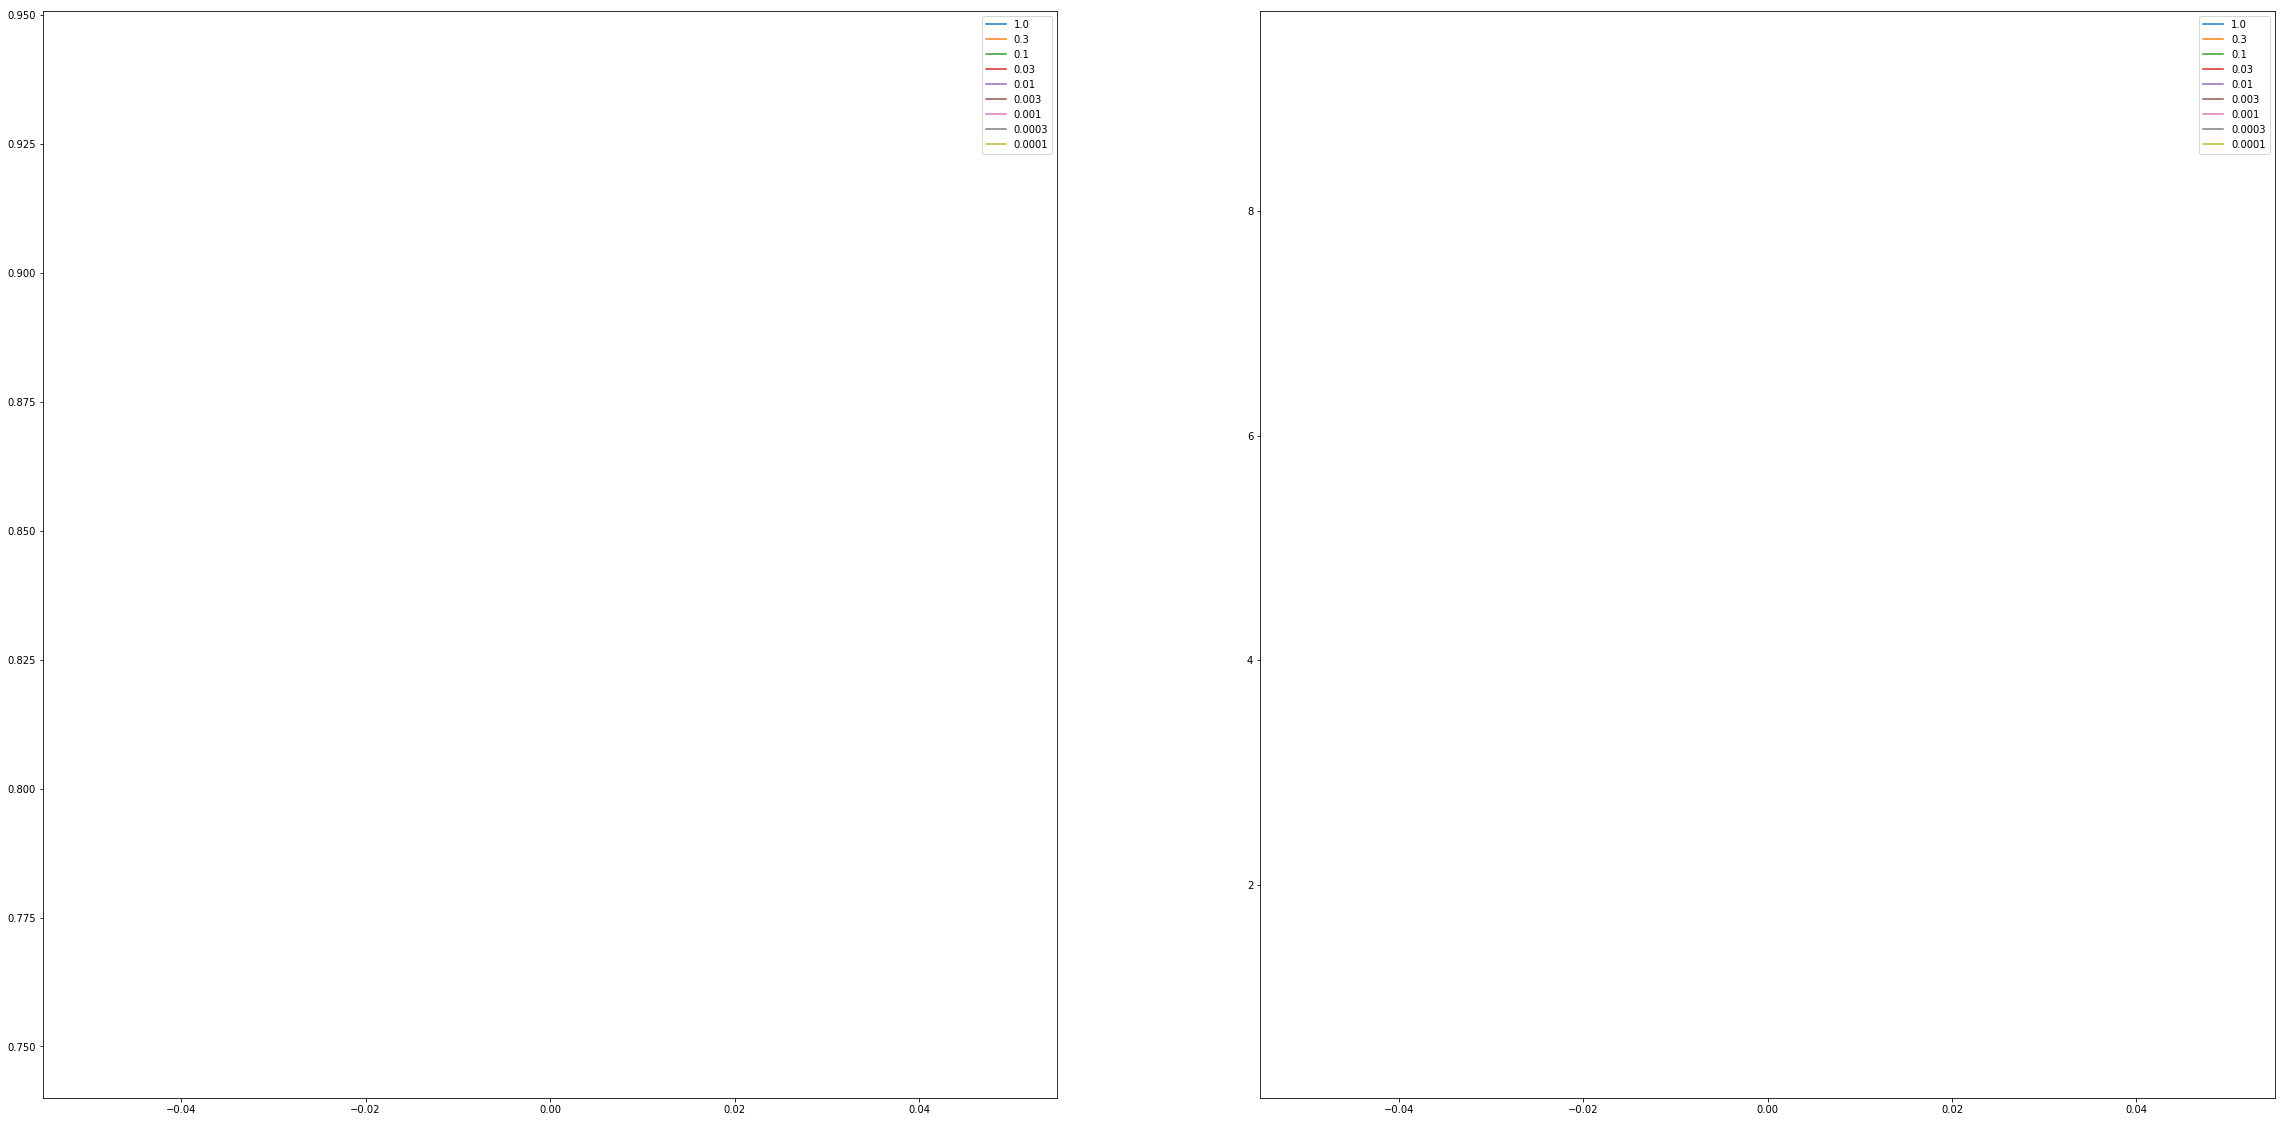

In [26]:
_, axes = plt.subplots(1,2,figsize=(40,20))
reg_show = reg_candidate
for key in reg_show:
    axes[0].plot(loss_hist_myfob[key]['acc'], label=str(key))
    axes[1].plot(loss_hist_myfob[key]['val'], label=str(key))

axes[0].legend()
axes[1].legend()

In [27]:
loss_hist_myfob

{1.0: {'train': 4.076283328300575, 'val': 4.5233908996634975, 'acc': 0.84364},
 0.3: {'train': 5.74310751104948, 'val': 6.200910195675702, 'acc': 0.8544},
 0.1: {'train': 3.865146759832622, 'val': 4.26400200860259, 'acc': 0.83582},
 0.03: {'train': 8.945905870861477, 'val': 9.345651721882321, 'acc': 0.74962},
 0.01: {'train': 4.418556973744657, 'val': 4.8934256101802145, 'acc': 0.78438},
 0.003: {'train': 3.879418838724849,
  'val': 4.1561557430174485,
  'acc': 0.84628},
 0.001: {'train': 0.3233450589725599,
  'val': 0.5422545323607901,
  'acc': 0.94128},
 0.0003: {'train': 3.8124386625630513,
  'val': 4.097533120076553,
  'acc': 0.84888},
 0.0001: {'train': 3.8231233394620743,
  'val': 4.0982925431782204,
  'acc': 0.84336},
 3e-05: {'train': 5.192582529392981, 'val': 5.861138069209582, 'acc': 0.8371},
 1e-05: {'train': 7.631682744101872, 'val': 8.255822636433937, 'acc': 0.75366}}

In [32]:
loss_hist_fob

{1.0: {'train': 6.479618935357957, 'val': 6.423560653897584, 'acc': 0.7593},
 0.3: {'train': 6.876419128439877, 'val': 7.243364749531413, 'acc': 0.76328},
 0.1: {'train': 4.435769674162744, 'val': 4.588832596496401, 'acc': 0.84428},
 0.03: {'train': 4.824000366150387, 'val': 6.060022825664626, 'acc': 0.76614},
 0.01: {'train': 6.971433393538944, 'val': 7.085428709754026, 'acc': 0.74926},
 0.003: {'train': 15.941330270161705,
  'val': 16.506002319521567,
  'acc': 0.5778},
 0.001: {'train': 3.537570909848289, 'val': 4.077963299225447, 'acc': 0.8385},
 0.0003: {'train': 0.4498931951021474,
  'val': 0.8449704319575007,
  'acc': 0.93038},
 0.0001: {'train': 11.076466817704459,
  'val': 11.195109361919643,
  'acc': 0.66034}}

In [30]:
with open('data/loss_hist_jac.pk', 'rb') as f:    
    loss_hist_jac = pickle.load(f)

In [31]:
loss_hist_jac

{1.0: {'train': 3.9589602594877262, 'val': 4.1033336863767715, 'acc': 0.85704},
 0.3: {'train': 4.1565993833134725, 'val': 4.302544057634495, 'acc': 0.84602},
 0.1: {'train': 0.3492595686152364, 'val': 0.8332069805602897, 'acc': 0.91876},
 0.03: {'train': 0.3387333083301778, 'val': 0.5326936996824719, 'acc': 0.9421},
 0.01: {'train': 7.51676230771201, 'val': 7.316841843875594, 'acc': 0.7596},
 0.003: {'train': 4.810869755252959, 'val': 5.019160560687819, 'acc': 0.84654},
 0.001: {'train': 5.3654166313194835,
  'val': 5.644412577660888,
  'acc': 0.85192},
 0.0003: {'train': 4.315937372177667,
  'val': 4.519585442373058,
  'acc': 0.84726},
 0.0001: {'train': 5.88105757463546, 'val': 6.319257965112039, 'acc': 0.85536}}

In [33]:
with open('data/loss_hist_db.pk', 'rb') as f:    
    loss_hist_db = pickle.load(f)

In [34]:
loss_hist_db

{1.0: {'train': 0.30622138560468715,
  'val': 0.3532080801917719,
  'acc': 0.90808},
 0.3: {'train': 0.40253484568056014,
  'val': 0.4498061370635032,
  'acc': 0.90846},
 0.1: {'train': 15.550804539332313, 'val': 14.988565955037064, 'acc': 0.54356},
 0.03: {'train': 0.499057249181374, 'val': 0.8541616110444933, 'acc': 0.90298},
 0.01: {'train': 9.422486142506676, 'val': 9.926099288891283, 'acc': 0.7506},
 0.003: {'train': 0.2718980761229343,
  'val': 0.5609236087749949,
  'acc': 0.94044},
 0.001: {'train': 3.1654728579791085,
  'val': 3.3728638012021506,
  'acc': 0.8487},
 0.0003: {'train': 2.951816171400308,
  'val': 3.348000822357229,
  'acc': 0.85686},
 0.0001: {'train': 1.0032842613974704,
  'val': 1.161783873450739,
  'acc': 0.87926}}

In [41]:
coef = {
    'db':0.003,
    'fob':0.0003,
    'myfob':0.001,
    'jac':0.03,
    'NI':0.003
}

In [38]:
np.save('data/init_weight_mnist', init_weight_copy)

In [40]:
np.load('data/init_weight_mnist.npy', allow_pickle=True)

array([array([[[[ 0.03879467,  0.04180132,  0.02118748, -0.07963803,
          -0.04738054, -0.09441105, -0.04570386,  0.04850742,
          -0.13362142, -0.09165411,  0.07136966, -0.03671246,
           0.02902691,  0.07039627, -0.12564786,  0.14126672,
          -0.06547153,  0.05867364,  0.11773531,  0.04220489,
           0.0576845 , -0.08650757,  0.1310951 ,  0.00494756,
          -0.03625003,  0.12258859,  0.09751426, -0.04335266,
          -0.10622896, -0.08249158,  0.12968756, -0.10683317]],

        [[-0.10766605,  0.03153373,  0.02195324, -0.06700226,
           0.07947798,  0.06466343,  0.08137083,  0.11936675,
          -0.08888806, -0.07786494,  0.10770838,  0.08085886,
           0.01655532,  0.05050474, -0.085133  ,  0.03890687,
          -0.05038062, -0.08150895, -0.03034618, -0.11459313,
           0.03289554, -0.02335312, -0.1061966 , -0.09142144,
          -0.00140271,  0.10314016, -0.10909945,  0.05135497,
           0.06543493, -0.07056212,  0.1263928 , -0.12043236